In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Shup up these stupid warnings
!pip install shutup
import shutup
shutup.please()

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 13.8MB/s]


In [ ]:
9# Assign the ticker list that we want to scrap
tickers_list = ['CHD', 'KHC', 'SJM', 'PM', 'WMT', 'MDLZ', 'MKC', 'TSN', 'HRL', 'EL',
                'ABBV', 'A', 'BIIB', 'COR', 'CNC', 'DVA', 'XRAY', 'EW', 'ELV', 'GILD',
                'NWS','FOX', 'GOOGL', 'CHTR', 'CMCSA', 'T', 'DIS', 'IPG', 'META', 'VZ']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}


In [ ]:
# take a peak!
dow_prices

{'CHD':                   open        high         low       close   adjclose  \
 2017-01-03   44.250000   44.529999   43.849998   44.340000  40.431252   
 2017-01-04   44.520000   44.970001   44.410000   44.700001  40.759510   
 2017-01-05   44.709999   44.910000   44.480000   44.889999  40.932758   
 2017-01-06   44.869999   44.970001   44.450001   44.869999  40.914524   
 2017-01-09   44.650002   44.730000   43.889999   44.299999  40.394779   
 ...                ...         ...         ...         ...        ...   
 2021-12-23   99.610001  100.339996   99.400002   99.529999  97.179291   
 2021-12-27   99.610001  100.360001   99.370003  100.360001  97.989685   
 2021-12-28  100.489998  100.769997   99.949997  100.180000  97.813942   
 2021-12-29  100.430000  101.239998  100.260002  100.980003  98.595047   
 2021-12-30  101.209999  101.599998  100.330002  101.419998  99.024651   
 
              volume ticker  
 2017-01-03  3126600    CHD  
 2017-01-04  1787300    CHD  
 2017-01-05  

In [ ]:
# let's extract just the data we need (adjclose)
# get the adjclose price for the CHD (one sample)
prep_data = pd.DataFrame(dow_prices['CHD']['adjclose']).rename(columns = {"adjclose":"CHD"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data.head(n=10)

CHD        KHC         SJM         PM        WMT       MDLZ  \
2017-01-03  40.431252  64.479103  105.112808  63.832024  60.387119  38.699055   
2017-01-04  40.759510  64.110786  104.754204  63.265293  60.738922  38.655910   
2017-01-05  40.932758  63.742458  105.283951  63.762024  60.870850  38.828484   
2017-01-06  40.914524  63.580391  105.169876  64.258804  60.035316  38.880272   
2017-01-09  40.394779  63.403587  104.330383  63.887989  60.431087  38.561008   
2017-01-10  39.738247  63.285725  104.925362  63.335224  60.008942  38.112309   
2017-01-11  39.720005  63.911900  106.482056  63.279259  60.272778  38.888889   
2017-01-12  39.637936  64.398087  106.408707  63.328251  59.780258  38.733566   
2017-01-13  39.920609  64.110786  106.767296  63.251278  59.041470  38.483337   
2017-01-17  40.595379  64.766403  107.794212  64.622650  60.176044  38.742203   

                  MKC        TSN        HRL         EL  ...        NWS  FOX  \
2017-01-03  41.740162  53.131931  30.319880  71.806633  ...  11.020006  NaN   
2017-01-04  41.619743  53.887562  30.809601  73.078781  ...  11.202911  NaN   
2017-01-05  40.803574  54.167740  31.067350  72.985939  ...  11.202911  NaN   
2017-01-06  40.763443  53.760201  31.222010  73.505936  ...  11.202911  NaN   
2017-01-09  40.201492  53.191357  30.569046  72.651642  ...  11.340089  NaN   
2017-01-10  40.045395  51.968746  30.001986  71.825218  ...  11.431541  NaN   
2017-01-11  40.241638  52.181026  30.130861  72.735214  ...  11.477267  NaN   
2017-01-12  40.451241  52.376289  30.562544  73.487358  ...  11.385815  NaN   
2017-01-13  40.750053  52.631001  30.674761  73.162354  ...  11.385815  NaN   
2017-01-17  41.334297  52.911190  31.382713  74.146637  ...  11.614446  NaN   

                GOOGL        CHTR      CMCSA          T         DIS  \
2017-01-03  40.400501  285.769989  29.753428  18.892864  101.584358   
2017-01-04  40.388500  291.549988  30.106771  18.783072  102.886719   
2017-01-05  40.651001  296.170013  30.227413  18.730375  102.829254   
2017-01-06  41.260502  298.160004  30.279123  18.426579  104.361458   
2017-01-09  41.359001  296.260010  30.520430  18.194679  103.767731   
2017-01-10  41.300499  298.200012  30.559195  18.199146  103.786880   
2017-01-11  41.493000  299.540009  30.899620  18.109955  104.801964   
2017-01-12  41.476501  297.190002  30.774662  18.288336  102.972900   
2017-01-13  41.547001  298.429993  31.356359  18.266033  103.480438   
2017-01-17  41.373001  306.140015  31.265879  18.332928  103.394257   

                  IPG        META         VZ  
2017-01-03  17.956345  116.860001  38.593277  
2017-01-04  18.047998  118.690002  38.550854  
2017-01-05  17.643200  120.669998  38.635708  
2017-01-06  18.055635  123.410004  38.062557  
2017-01-09  17.956345  124.900002  37.648052  
2017-01-10  17.803587  124.349998  37.705223  
2017-01-11  18.101461  126.089996  37.490826  
2017-01-12  18.093824  126.620003  37.648052  
2017-01-13  18.009806  128.339996  37.555149  
2017-01-17  17.963987  127.870003  37.690933  

[10 rows x 30 columns]

In [ ]:
prep_data.shape

(1258, 30)

In [ ]:
# create return features for each ticker,
# we will just use a pct_change as the return
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# drop the na records
return_data.dropna(inplace=True)
return_data

CHD       KHC       SJM        PM       WMT      MDLZ  \
2019-03-14 -0.000150 -0.013312  0.005714  0.003240 -0.002843  0.001481   
2019-03-15  0.007023  0.006903  0.016659  0.011805  0.002036  0.009504   
2019-03-18 -0.008012 -0.001870  0.013639 -0.001321  0.012599  0.005021   
2019-03-19 -0.007179  0.003122 -0.001028 -0.002535  0.001906  0.004163   
2019-03-20 -0.008436 -0.003423  0.001497  0.002652 -0.012118 -0.001244   
...              ...       ...       ...       ...       ...       ...   
2021-12-23  0.001308  0.003987 -0.001127  0.000215 -0.002217  0.001697   
2021-12-27  0.008339  0.005107  0.006467  0.006564  0.009104  0.008931   
2021-12-28 -0.001793  0.012136  0.010086  0.003421  0.014351  0.007479   
2021-12-29  0.007986 -0.001394 -0.000739  0.004688 -0.000490  0.005454   
2021-12-30  0.004357 -0.004189  0.001776 -0.000424  0.003223 -0.004090   

                 MKC       TSN       HRL        EL  ...       NWS       FOX  \
2019-03-14  0.001868  0.006828 -0.002103  0.003450  ... -0.013889  0.019388   
2019-03-15  0.003801  0.005240 -0.003279  0.017189  ... -0.003130  0.026527   
2019-03-18  0.005143  0.001687 -0.000235  0.002212  ... -0.000785 -0.003901   
2019-03-19 -0.002914  0.006735 -0.000705 -0.014715  ... -0.008641 -0.032061   
2019-03-20 -0.006486 -0.013532 -0.005174 -0.006285  ... -0.000792 -0.049305   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-23 -0.003855  0.003414  0.001467  0.011861  ...  0.021286  0.011134   
2021-12-27  0.011824  0.011031  0.004396  0.008962  ...  0.014634  0.003188   
2021-12-28  0.008818  0.005919  0.009379 -0.003981  ...  0.002185  0.004333   
2021-12-29  0.006950 -0.002885  0.002065  0.006199  ... -0.006978 -0.011217   
2021-12-30  0.003360 -0.001157  0.000824 -0.007404  ... -0.001757  0.010762   

               GOOGL      CHTR     CMCSA         T       DIS       IPG  \
2019-03-14 -0.005446  0.013156  0.007836  0.000000  0.003418  0.008547   
2019-03-15 -0.001870  0.009101  0.015049  0.012880  0.004193 -0.003568   
2019-03-18 -0.001470  0.004018 -0.013591  0.004239 -0.016006 -0.005819   
2019-03-19  0.011703  0.008675 -0.003507 -0.003896 -0.027581  0.003152   
2019-03-20  0.019934  0.005521 -0.007793 -0.005541 -0.000091 -0.015261   
...              ...       ...       ...       ...       ...       ...   
2021-12-23  0.003425  0.013301  0.020396  0.003632  0.011522  0.004361   
2021-12-27  0.006738  0.006247  0.008795 -0.003619 -0.005403  0.028223   
2021-12-28 -0.008245  0.005273  0.000793  0.001614  0.015707 -0.001319   
2021-12-29 -0.000218  0.000747  0.001584 -0.007252 -0.002126 -0.001586   
2021-12-30 -0.003099  0.001447  0.000000  0.005682  0.006844 -0.000265   

                META        VZ  
2019-03-14 -0.018458  0.005030  
2019-03-15 -0.024622  0.007593  
2019-03-18 -0.033197 -0.005480  
2019-03-19  0.006855 -0.009816  
2019-03-20  0.023952  0.002957  
...              ...       ...  
2021-12-23  0.014495 -0.001705  
2021-12-27  0.032633  0.000000  
2021-12-28  0.000116  0.000759  
2021-12-29 -0.009474 -0.006828  
2021-12-30  0.004141 -0.002101  

[707 rows x 30 columns]

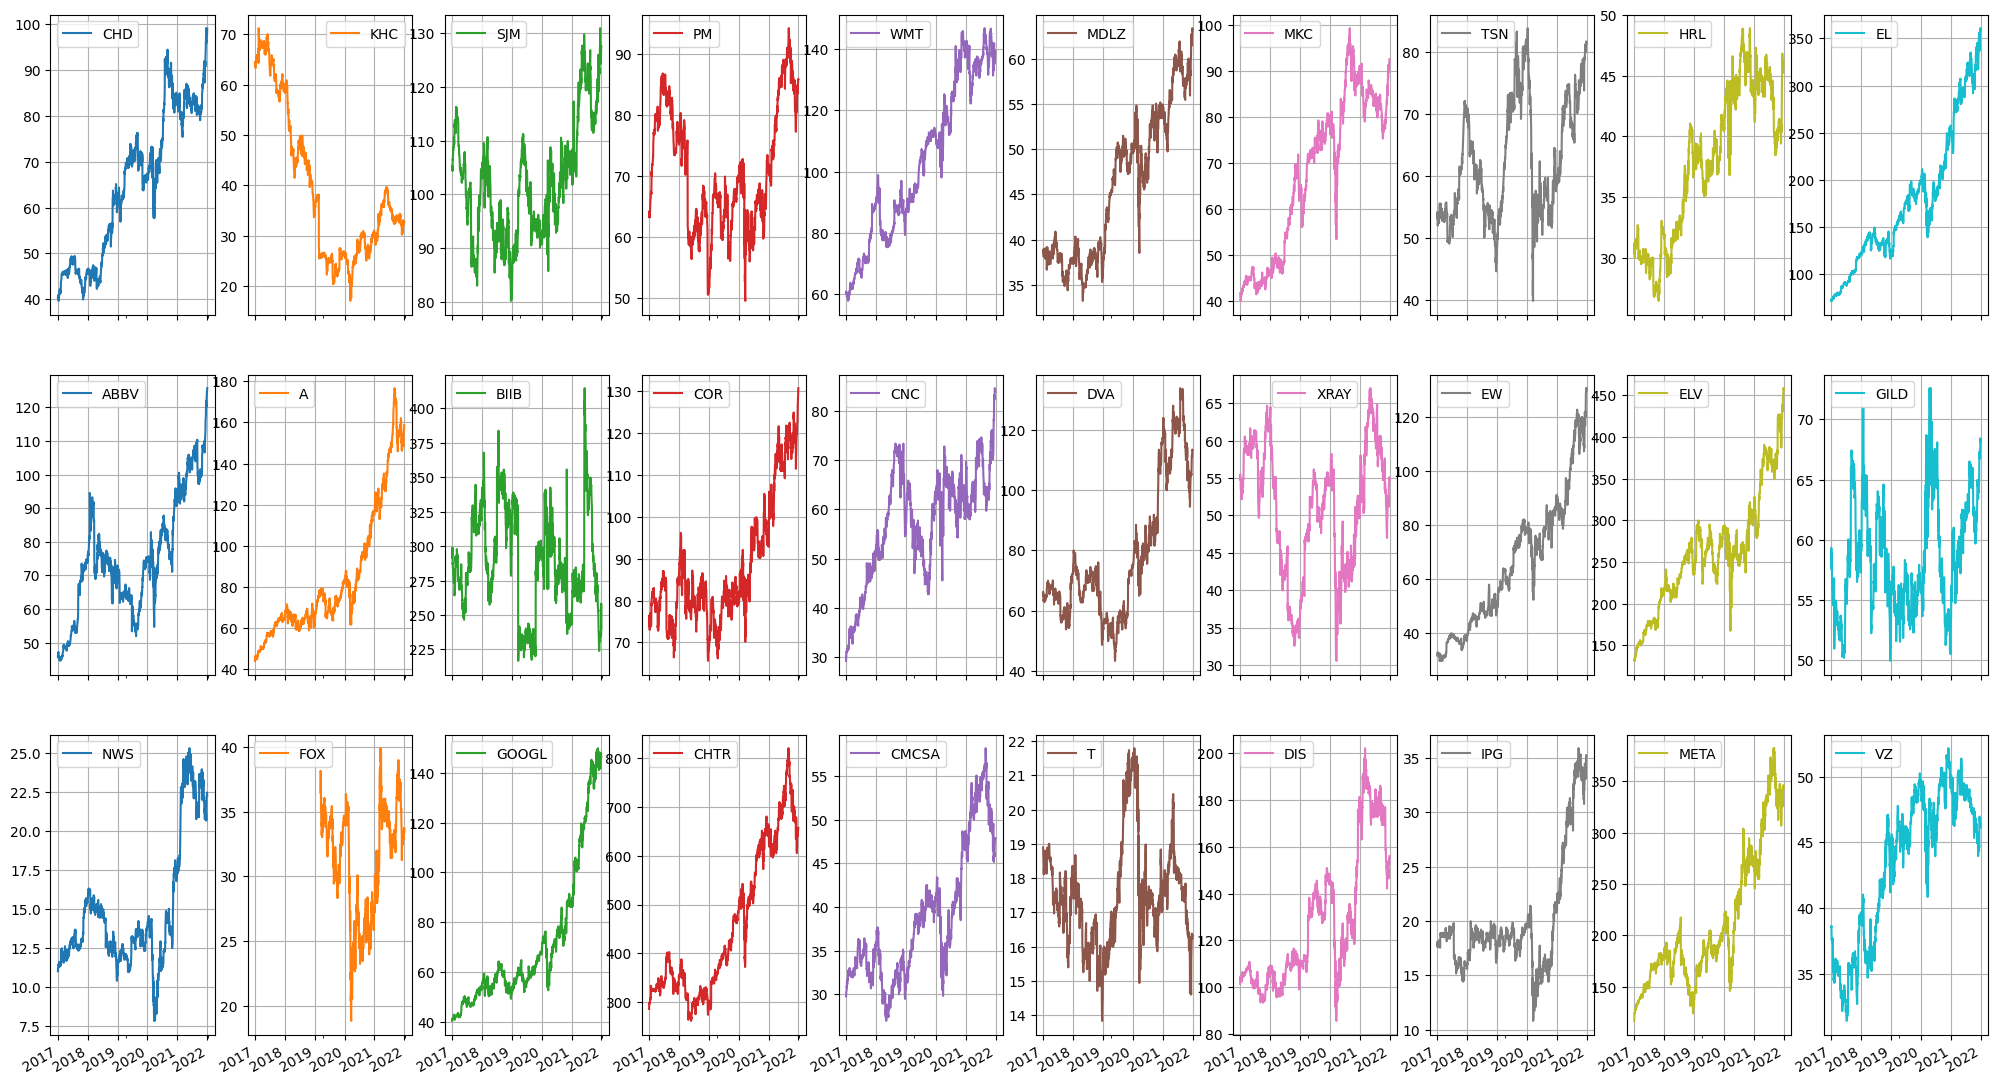

In [ ]:
prep_data.plot(subplots=True,
        grid=True,
        layout=(3,10),
         figsize=(25,15))
plt.show()

In [ ]:
# Creating new columns for each stock's rolling averages
for ticker in tickers_list:
    prep_data[f'{ticker}_9-day'] = prep_data[ticker].rolling(9).mean()
    prep_data[f'{ticker}_21-day'] = prep_data[ticker].rolling(21).mean()

# Displaying the first 10 rows of the updated DataFrame
print(prep_data.head(n=10))


                  CHD        KHC         SJM         PM        WMT       MDLZ  \
2017-01-03  40.431252  64.479103  105.112808  63.832024  60.387119  38.699055   
2017-01-04  40.759510  64.110786  104.754204  63.265293  60.738922  38.655910   
2017-01-05  40.932758  63.742458  105.283951  63.762024  60.870850  38.828484   
2017-01-06  40.914524  63.580391  105.169876  64.258804  60.035316  38.880272   
2017-01-09  40.394779  63.403587  104.330383  63.887989  60.431087  38.561008   
2017-01-10  39.738247  63.285725  104.925362  63.335224  60.008942  38.112309   
2017-01-11  39.720005  63.911900  106.482056  63.279259  60.272778  38.888889   
2017-01-12  39.637936  64.398087  106.408707  63.328251  59.780258  38.733566   
2017-01-13  39.920609  64.110786  106.767296  63.251278  59.041470  38.483337   
2017-01-17  40.595379  64.766403  107.794212  64.622650  60.176044  38.742203   

                  MKC        TSN        HRL         EL  ...    T_9-day  \
2017-01-03  41.740162  53.131931  

In [ ]:
for ticker in tickers_list:
    prep_data[f'{ticker}_9-day'] = prep_data[ticker].rolling(9).mean().shift()
    prep_data[f'{ticker}_21-day'] = prep_data[ticker].rolling(21).mean().shift()
prep_data.dropna(inplace=True)
print(prep_data.head(n=10))

                  CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   
2019-04-18  69.757103  26.388172  104.673225  65.586105  95.816093  45.334999   
2019-04-22  69.681526  26.340137  105.124191  65.430878  95.063911  45.416447   
2019-04-23  69.388618  26.500254  105.557785  65.912155  95.713959  45.579369   
2019-04-24  69.237450  26.228045  106.112808  65.555069  96.141106  45.597466   
2019-04-25  69.350822  26.035902  105.124191  64.887482  96.131836  45.262592   

                  MKC        TSN        HRL          EL  ...    T_9-day  \
2019-04-11  71.538544  62.923485 

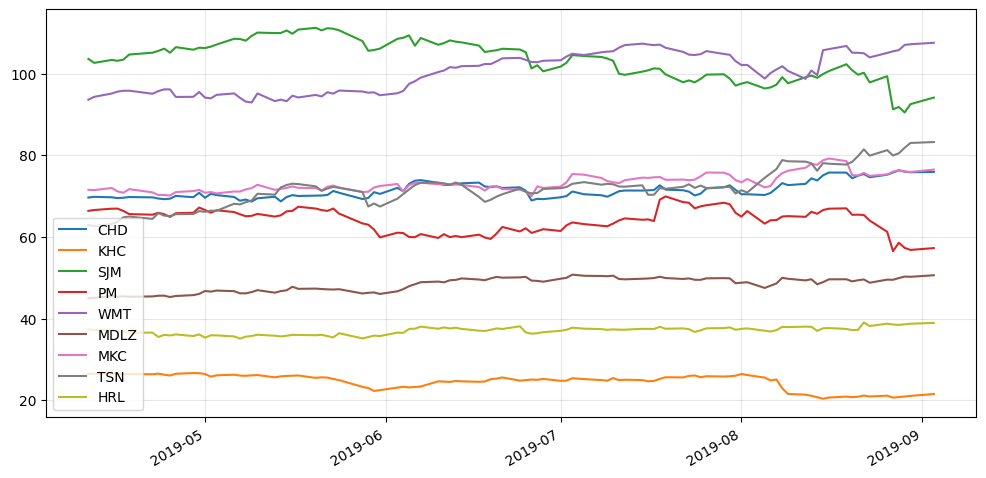

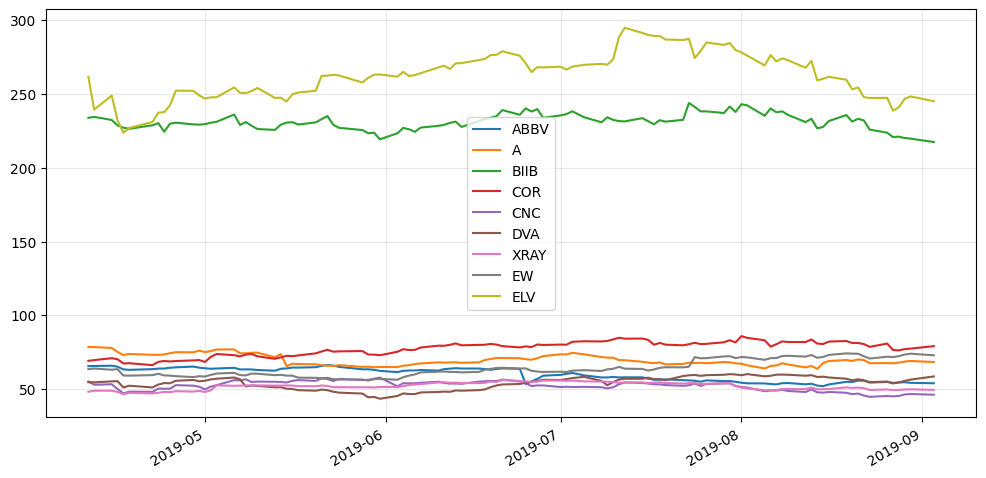

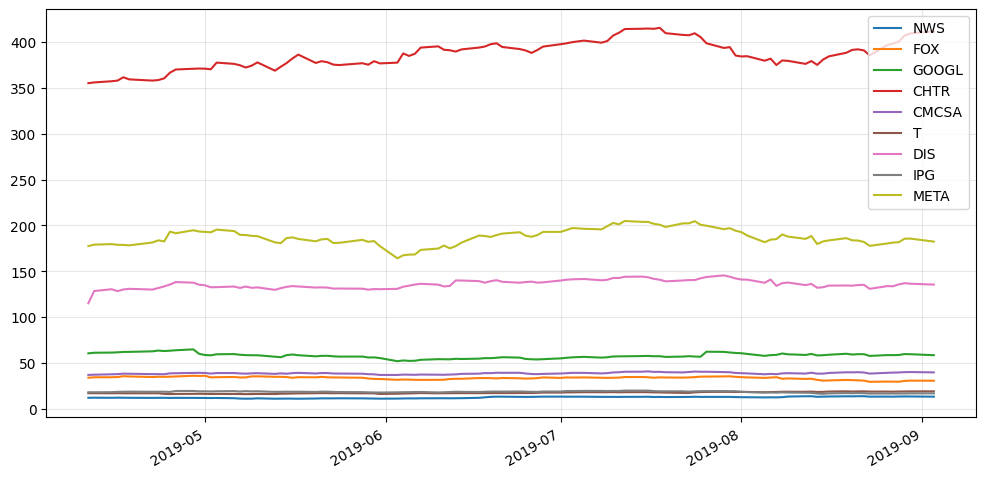

In [ ]:
prep_data.iloc[:100,0:9].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

prep_data.iloc[:100,10:19].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

prep_data.iloc[:100,20:29].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

**BUY AND HOLD STRATEGY**

In [ ]:
for ticker in tickers_list:
  prep_data[f'{ticker}_logClose'] = np.log(prep_data[ticker])
  prep_data[f'{ticker}_return'] = prep_data[f'{ticker}_logClose'].diff() # the difference will be positive or negative
print(prep_data.head())

                  CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   

                  MKC        TSN        HRL          EL  ...  T_logClose  \
2019-04-11  71.538544  62.923485  37.379993  160.415466  ...    2.833056   
2019-04-12  71.454987  62.631706  37.199207  159.919083  ...    2.833056   
2019-04-15  71.975098  63.135670  37.154003  159.518127  ...    2.827450   
2019-04-16  71.148445  63.710358  36.864723  162.133804  ...    2.834608   
2019-04-17  70.804771  64.788994  36.810486  161.837860  ...    2.825262   

            T_return  DIS_logClose  DIS_return  IPG_logC

In [ ]:
for ticker in tickers_list:
  prep_data.loc["2019-04-11",f'{ticker}_return'] = 0.0
prep_data.head()

CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   

                  MKC        TSN        HRL          EL  ...  T_logClose  \
2019-04-11  71.538544  62.923485  37.379993  160.415466  ...    2.833056   
2019-04-12  71.454987  62.631706  37.199207  159.919083  ...    2.833056   
2019-04-15  71.975098  63.135670  37.154003  159.518127  ...    2.827450   
2019-04-16  71.148445  63.710358  36.864723  162.133804  ...    2.834608   
2019-04-17  70.804771  64.788994  36.810486  161.837860  ...    2.825262   

            T_return  DIS_logClose  DIS_return  IPG_logClose  IPG_return  \
2019-04-11  0.000000      4.746602    0.000000      2.894451    0.000000   
2019-04-12  0.000000      4.855849    0.109247      2.890786   -0.003665   
2019-04-15 -0.005606      4.870958    0.015109      2.897646    0.006860   
2019-04-16  0.007157      4.854618   -0.016340      2.913922    0.016275   
2019-04-17 -0.009346      4.868759    0.014141      2.923295    0.009373   

            META_logClose  META_return  VZ_logClose  VZ_return  
2019-04-11       5.179027     0.000000     3.837923   0.000000  
2019-04-12       5.187944     0.008917     3.840992   0.003069  
2019-04-15       5.191010     0.003066     3.840481  -0.000511  
2019-04-16       5.186659    -0.004351     3.841843   0.001362  
2019-04-17       5.186156    -0.000503     3.824514  -0.017329  

[5 rows x 150 columns]

In [ ]:
print("Buy and hold returns")
for ticker in tickers_list:
  print(ticker+ ' : ' + str (np.exp(np.sum( prep_data[f'{ticker}_return'])) -1))

Buy and hold returns
CHD : 0.42206761312241015
KHC : 0.23934656085382078
SJM : 0.2316932743589637
PM : 0.29348570690336073
WMT : 0.4887117811800503
MDLZ : 0.4044948825785686
MKC : 0.2925229558373408
TSN : 0.2922233348816796
HRL : 0.23666873797893095
EL : 1.2324353456885904
ABBV : 0.9188828763928172
A : 1.0214962306976845
BIIB : 0.0263866831485684
COR : 0.8907057645240415
CNC : 0.5234898646201125
DVA : 1.0735858789029495
XRAY : 0.13761748526858808
EW : 1.0594661111268424
ELV : 0.7498914603752798
GILD : 0.23465554955350032
NWS : 0.8562011399841691
FOX : -0.004911963258303453
GOOGL : 1.4173563096737314
CHTR : 0.8500492061048563
CMCSA : 0.2953929824593995
T : -0.039754164677662684
DIS : 0.3536504417598758
IPG : 0.944545222086214
META : 0.9399470227480693
VZ : -0.006035787647611479


**Momentum trading strategy**

In [ ]:
for ticker in tickers_list:
# the np.where() function is similar to the Excel =IF() statement
  prep_data[f'{ticker}_invested'] = np.where( prep_data[f'{ticker}_9-day'] > prep_data[f'{ticker}_21-day'], 1, 0)
prep_data.head()

CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   

                  MKC        TSN        HRL          EL  ...  NWS_invested  \
2019-04-11  71.538544  62.923485  37.379993  160.415466  ...             0   
2019-04-12  71.454987  62.631706  37.199207  159.919083  ...             0   
2019-04-15  71.975098  63.135670  37.154003  159.518127  ...             1   
2019-04-16  71.148445  63.710358  36.864723  162.133804  ...             1   
2019-04-17  70.804771  64.788994  36.810486  161.837860  ...             1   

            FOX_invested  GOOGL_invested  CHTR_invested  CMCSA_invested  \
2019-04-11             0               1              0               1   
2019-04-12             0               1              0               1   
2019-04-15             0               1              0               1   
2019-04-16             0               1              0               1   
2019-04-17             0               1              0               1   

            T_invested  DIS_invested  IPG_invested  META_invested  VZ_invested  
2019-04-11           1             1             0              1            1  
2019-04-12           1             1             0              1            1  
2019-04-15           1             1             0              1            0  
2019-04-16           1             1             1              1            1  
2019-04-17           1             1             1              1            1  

[5 rows x 180 columns]

In [ ]:
#for ticker in tickers_list:
#  print(prep_data[f'{ticker}_invested'].value_counts())

**Entering and leaving the market using the momentum trading strategy**

In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
for ticker in tickers_list:
  prep_data[f'{ticker}_signal'] = prep_data[f'{ticker}_invested'].diff()

prep_data
  #print(prep_data[f'{ticker}_signal'].value_counts())

CHD        KHC         SJM         PM         WMT  \
2019-04-11  69.634277  26.412189  103.597870  66.377899   93.605949   
2019-04-12  69.813797  26.476236  102.626595  66.579727   94.311707   
2019-04-15  69.700417  26.532280  103.355064  66.905777   95.119629   
2019-04-16  69.511436  26.452215  103.138268  66.921288   95.583946   
2019-04-17  69.587044  26.332127  103.424446  66.354622   95.797539   
...               ...        ...         ...        ...         ...   
2021-12-23  97.179291  32.357498  125.385170  84.647392  135.770447   
2021-12-27  97.989685  32.522736  126.195992  85.203041  137.006561   
2021-12-28  97.813942  32.917446  127.468788  85.494514  138.972687   
2021-12-29  98.595047  32.871544  127.374527  85.895302  138.904572   
2021-12-30  99.024651  32.733856  127.600800  85.858864  139.352280   

                 MDLZ        MKC        TSN        HRL          EL  ...  \
2019-04-11  44.954857  71.538544  62.923485  37.379993  160.415466  ...   
2019-04-12  45.063473  71.454987  62.631706  37.199207  159.919083  ...   
2019-04-15  45.506950  71.975098  63.135670  37.154003  159.518127  ...   
2019-04-16  45.362148  71.148445  63.710358  36.864723  162.133804  ...   
2019-04-17  45.461704  70.804771  64.788994  36.810486  161.837860  ...   
...               ...        ...        ...        ...         ...  ...   
2021-12-23  62.032177  89.659439  80.275024  45.465267  356.801025  ...   
2021-12-27  62.586197  90.719574  81.160500  45.665134  359.998657  ...   
2021-12-28  63.054264  91.519501  81.640892  46.093422  358.565582  ...   
2021-12-29  63.398159  92.155602  81.405396  46.188599  360.788361  ...   
2021-12-30  63.138866  92.465210  81.311195  46.226669  358.117157  ...   

            NWS_signal  FOX_signal  GOOGL_signal  CHTR_signal  CMCSA_signal  \
2019-04-11         NaN         NaN           NaN          NaN           NaN   
2019-04-12         0.0         0.0           0.0          0.0           0.0   
2019-04-15         1.0         0.0           0.0          0.0           0.0   
2019-04-16         0.0         0.0           0.0          0.0           0.0   
2019-04-17         0.0         0.0           0.0          0.0           0.0   
...                ...         ...           ...          ...           ...   
2021-12-23         0.0         0.0           0.0          0.0           0.0   
2021-12-27         0.0         1.0          -1.0          0.0           0.0   
2021-12-28         1.0         0.0           1.0          0.0           0.0   
2021-12-29         0.0         0.0           0.0          1.0           0.0   
2021-12-30         0.0         0.0           0.0          0.0           0.0   

            T_signal  DIS_signal  IPG_signal  META_signal  VZ_signal  
2019-04-11       NaN         NaN         NaN          NaN        NaN  
2019-04-12       0.0         0.0         0.0          0.0        0.0  
2019-04-15       0.0         0.0         0.0          0.0       -1.0  
2019-04-16       0.0         0.0         1.0          0.0        1.0  
2019-04-17       0.0         0.0         0.0          0.0        0.0  
...              ...         ...         ...          ...        ...  
2021-12-23       0.0         0.0         0.0          0.0        0.0  
2021-12-27       1.0         0.0         0.0          0.0        0.0  
2021-12-28       0.0         0.0         0.0          0.0        0.0  
2021-12-29       0.0         0.0         0.0          0.0        0.0  
2021-12-30       0.0         0.0         0.0          0.0        0.0  

[687 rows x 210 columns]

In [ ]:
prep_data.head()

CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   

                  MKC        TSN        HRL          EL  ...  NWS_signal  \
2019-04-11  71.538544  62.923485  37.379993  160.415466  ...         NaN   
2019-04-12  71.454987  62.631706  37.199207  159.919083  ...         0.0   
2019-04-15  71.975098  63.135670  37.154003  159.518127  ...         1.0   
2019-04-16  71.148445  63.710358  36.864723  162.133804  ...         0.0   
2019-04-17  70.804771  64.788994  36.810486  161.837860  ...         0.0   

            FOX_signal  GOOGL_signal  CHTR_signal  CMCSA_signal  T_signal  \
2019-04-11         NaN           NaN          NaN           NaN       NaN   
2019-04-12         0.0           0.0          0.0           0.0       0.0   
2019-04-15         0.0           0.0          0.0           0.0       0.0   
2019-04-16         0.0           0.0          0.0           0.0       0.0   
2019-04-17         0.0           0.0          0.0           0.0       0.0   

            DIS_signal  IPG_signal  META_signal  VZ_signal  
2019-04-11         NaN         NaN          NaN        NaN  
2019-04-12         0.0         0.0          0.0        0.0  
2019-04-15         0.0         0.0          0.0       -1.0  
2019-04-16         0.0         1.0          0.0        1.0  
2019-04-17         0.0         0.0          0.0        0.0  

[5 rows x 210 columns]

In [ ]:
for ticker in tickers_list:
  prep_data.loc["2019-04-11",f'{ticker}_signal'] = 1.0

prep_data.head()

CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   

                  MKC        TSN        HRL          EL  ...  NWS_signal  \
2019-04-11  71.538544  62.923485  37.379993  160.415466  ...         1.0   
2019-04-12  71.454987  62.631706  37.199207  159.919083  ...         0.0   
2019-04-15  71.975098  63.135670  37.154003  159.518127  ...         1.0   
2019-04-16  71.148445  63.710358  36.864723  162.133804  ...         0.0   
2019-04-17  70.804771  64.788994  36.810486  161.837860  ...         0.0   

            FOX_signal  GOOGL_signal  CHTR_signal  CMCSA_signal  T_signal  \
2019-04-11         1.0           1.0          1.0           1.0       1.0   
2019-04-12         0.0           0.0          0.0           0.0       0.0   
2019-04-15         0.0           0.0          0.0           0.0       0.0   
2019-04-16         0.0           0.0          0.0           0.0       0.0   
2019-04-17         0.0           0.0          0.0           0.0       0.0   

            DIS_signal  IPG_signal  META_signal  VZ_signal  
2019-04-11         1.0         1.0          1.0        1.0  
2019-04-12         0.0         0.0          0.0        0.0  
2019-04-15         0.0         0.0          0.0       -1.0  
2019-04-16         0.0         1.0          0.0        1.0  
2019-04-17         0.0         0.0          0.0        0.0  

[5 rows x 210 columns]

**Let's see the trading days**

In [ ]:
# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!

for ticker in tickers_list:
  prep_data[f'{ticker}_system_return'] = prep_data[f'{ticker}_invested'] * prep_data[f'{ticker}_return']
prep_data.head()


CHD        KHC         SJM         PM        WMT       MDLZ  \
2019-04-11  69.634277  26.412189  103.597870  66.377899  93.605949  44.954857   
2019-04-12  69.813797  26.476236  102.626595  66.579727  94.311707  45.063473   
2019-04-15  69.700417  26.532280  103.355064  66.905777  95.119629  45.506950   
2019-04-16  69.511436  26.452215  103.138268  66.921288  95.583946  45.362148   
2019-04-17  69.587044  26.332127  103.424446  66.354622  95.797539  45.461704   

                  MKC        TSN        HRL          EL  ...  \
2019-04-11  71.538544  62.923485  37.379993  160.415466  ...   
2019-04-12  71.454987  62.631706  37.199207  159.919083  ...   
2019-04-15  71.975098  63.135670  37.154003  159.518127  ...   
2019-04-16  71.148445  63.710358  36.864723  162.133804  ...   
2019-04-17  70.804771  64.788994  36.810486  161.837860  ...   

            NWS_system_return  FOX_system_return  GOOGL_system_return  \
2019-04-11           0.000000                0.0             0.000000   
2019-04-12           0.000000                0.0             0.010805   
2019-04-15          -0.007874                0.0             0.003103   
2019-04-16           0.007874                0.0             0.004377   
2019-04-17          -0.003142                0.0             0.006658   

            CHTR_system_return  CMCSA_system_return  T_system_return  \
2019-04-11                 0.0             0.000000         0.000000   
2019-04-12                 0.0             0.006315         0.000000   
2019-04-15                 0.0             0.011556        -0.005606   
2019-04-16                 0.0             0.004537         0.007157   
2019-04-17                 0.0             0.014195        -0.009346   

            DIS_system_return  IPG_system_return  META_system_return  \
2019-04-11           0.000000           0.000000            0.000000   
2019-04-12           0.109247          -0.000000            0.008917   
2019-04-15           0.015109           0.000000            0.003066   
2019-04-16          -0.016340           0.016275           -0.004351   
2019-04-17           0.014141           0.009373           -0.000503   

            VZ_system_return  
2019-04-11          0.000000  
2019-04-12          0.003069  
2019-04-15         -0.000000  
2019-04-16          0.001362  
2019-04-17         -0.017329  

[5 rows x 240 columns]

In [ ]:
print("Momentum Trading Strategy Returns")
MT_returns = []
for ticker in tickers_list:
  MT_returns.append(np.exp(np.sum( prep_data[f'{ticker}_system_return'])) -1)
  print(ticker+ ' : ' + str (np.exp(np.sum( prep_data[f'{ticker}_system_return'])) -1))


Momentum Trading Strategy Returns
CHD : 0.20989981144154957
KHC : 0.44323232774006627
SJM : -0.35703061256756063
PM : 0.15150864000164477
WMT : 0.060972125194584725
MDLZ : 0.20793232289088026
MKC : 0.33212852013074046
TSN : 0.09249660683423366
HRL : -0.0686106294351343
EL : 0.11090140267758763
ABBV : 0.37280706042615863
A : 0.7300675929976188
BIIB : -0.5813375173598108
COR : -0.009638119091386788
CNC : -0.23654928393431895
DVA : 0.6069308836195351
XRAY : -0.02516200350455433
EW : 0.37903761806874625
ELV : 0.26794652172245126
GILD : -0.08322347436800814
NWS : 0.4944396417844965
FOX : -0.09661249704445496
GOOGL : 0.7775671340103094
CHTR : 0.6919914578905972
CMCSA : 0.02006414400208012
T : -0.19320163890611852
DIS : 0.35496654824886
IPG : 0.19255132473495484
META : 0.5264263130068101
VZ : -0.14941280447380856


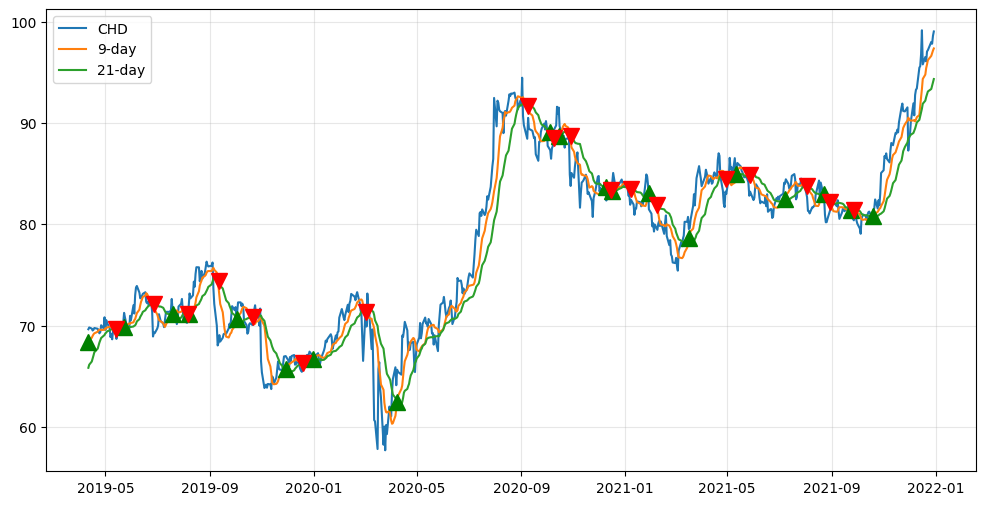

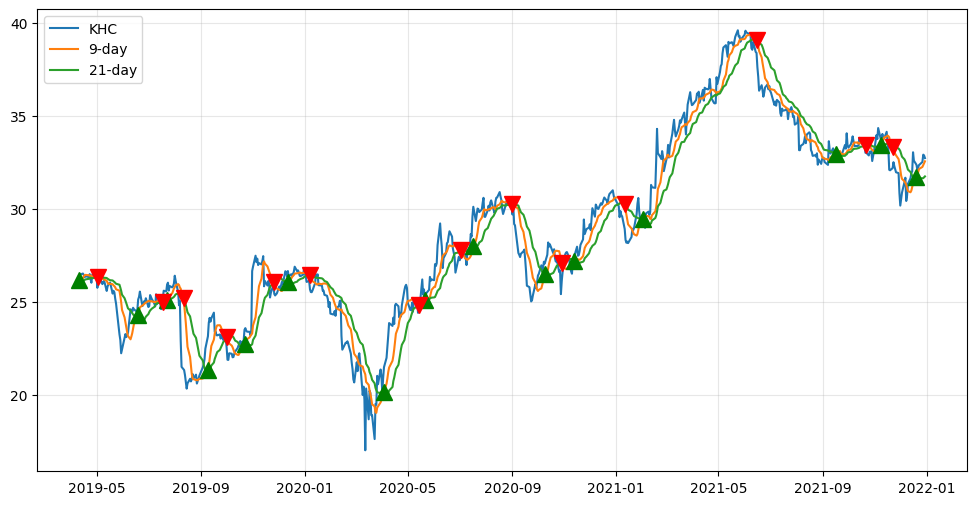

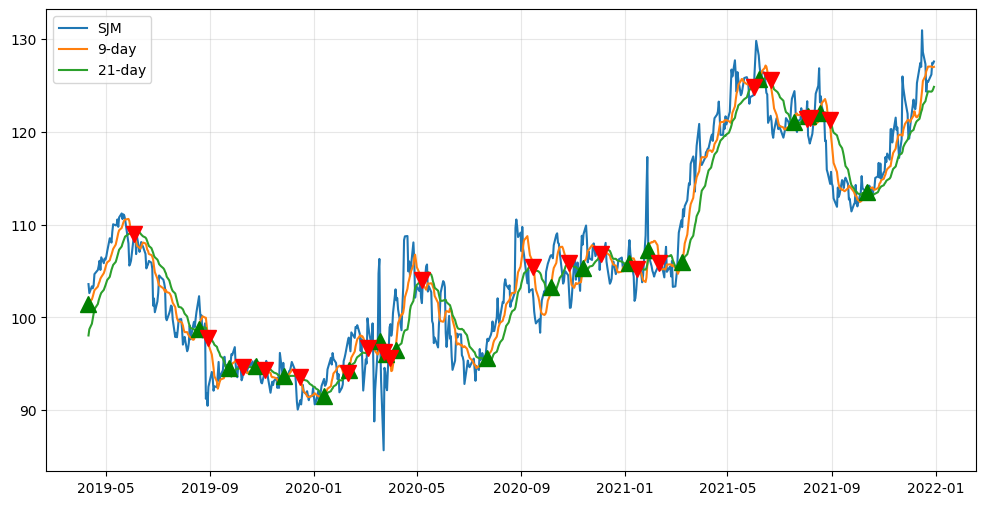

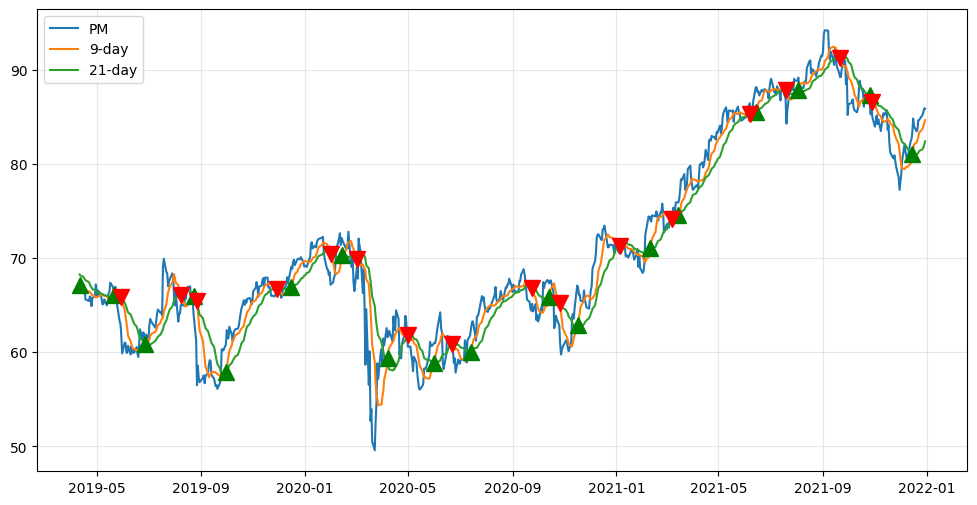

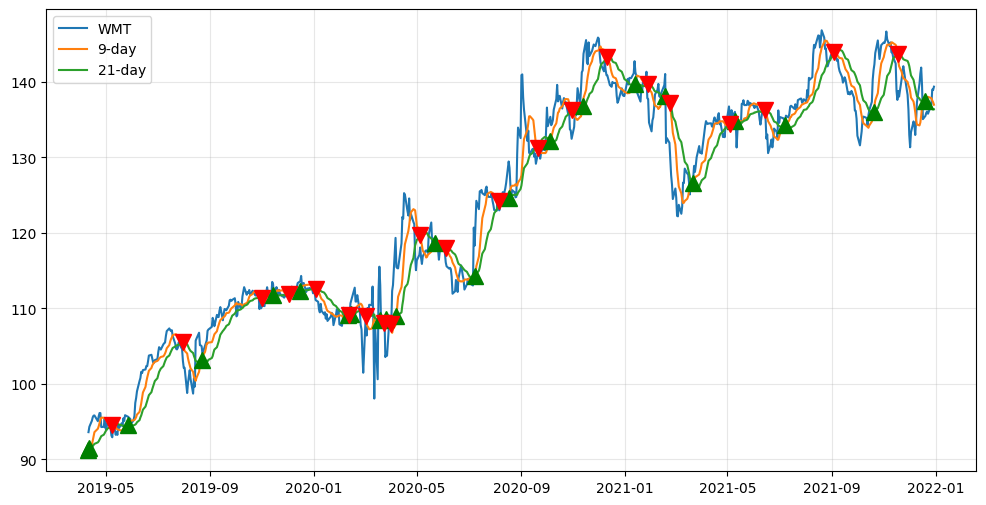

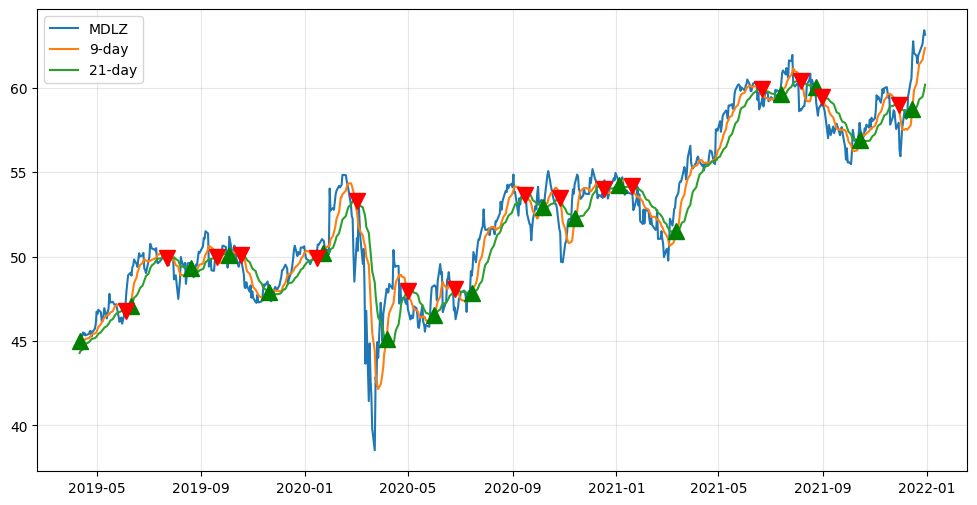

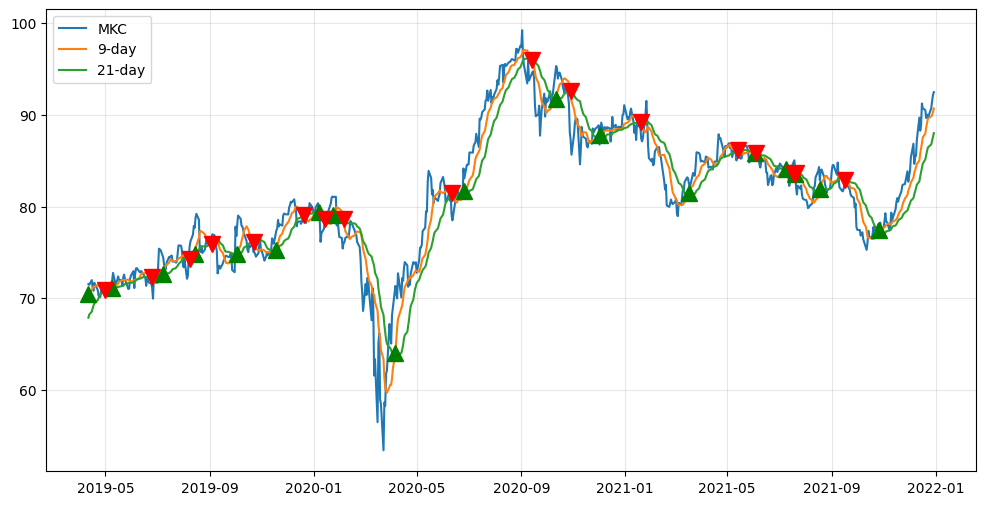

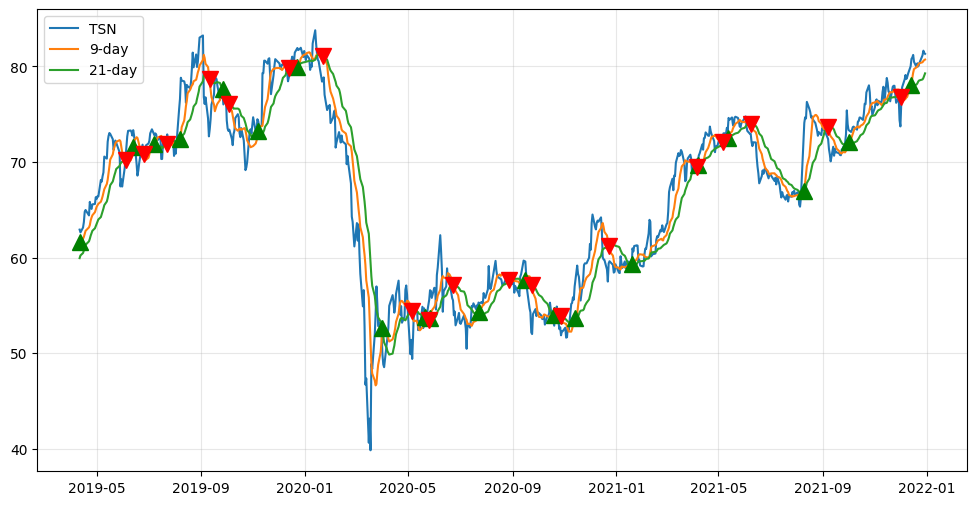

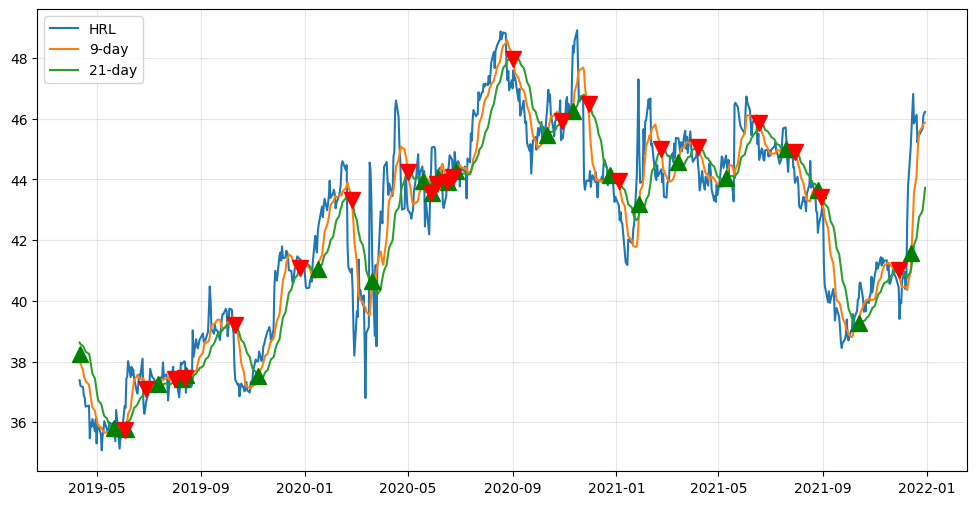

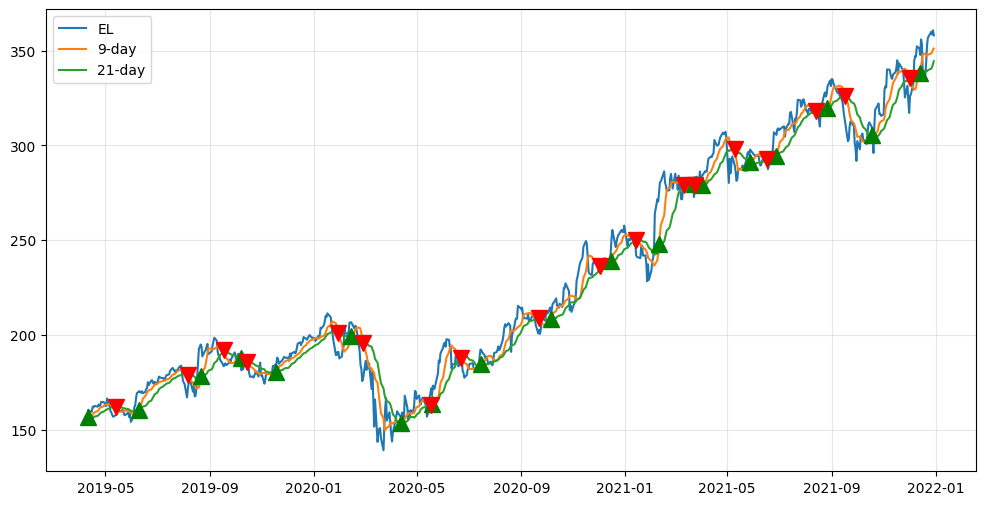

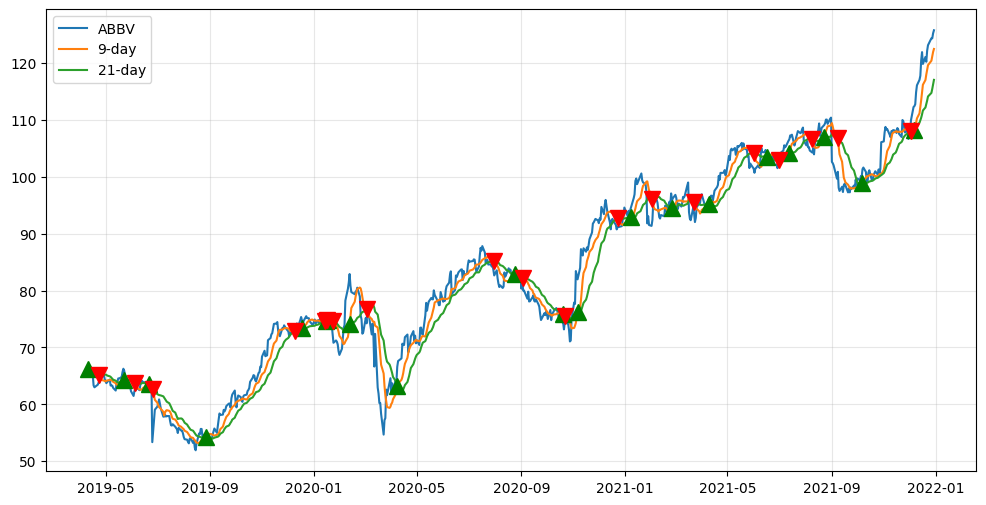

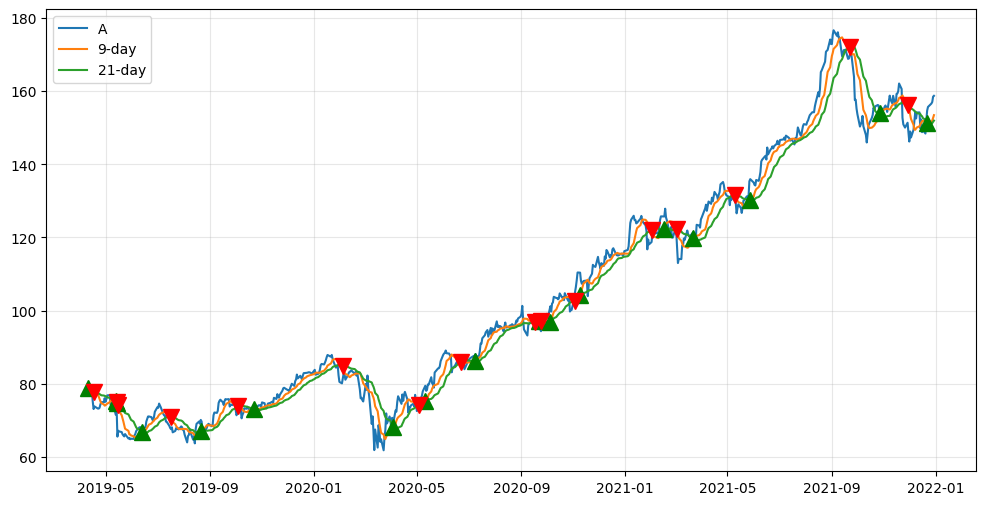

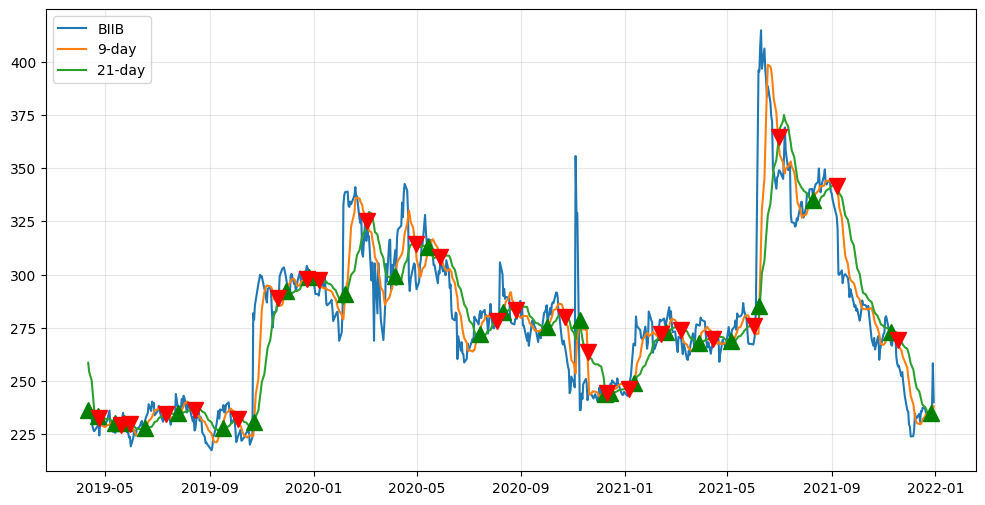

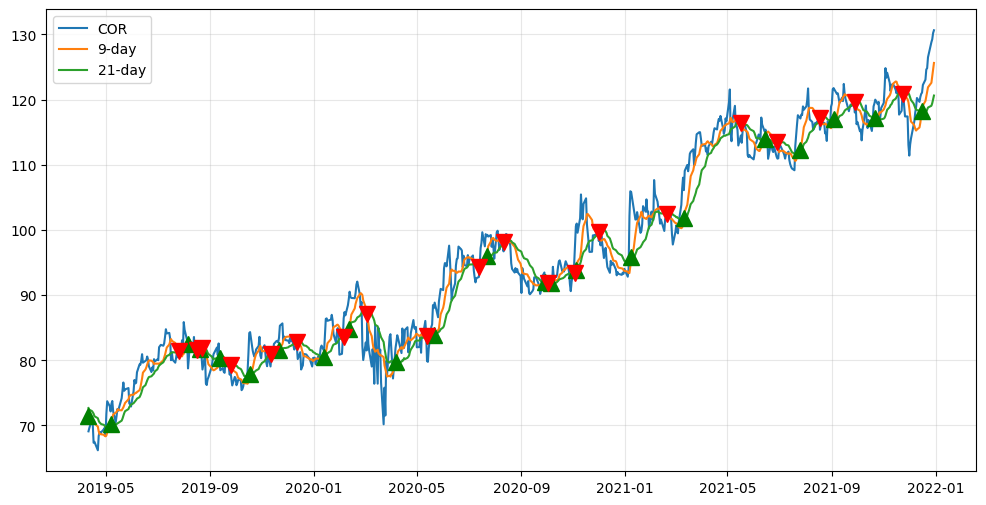

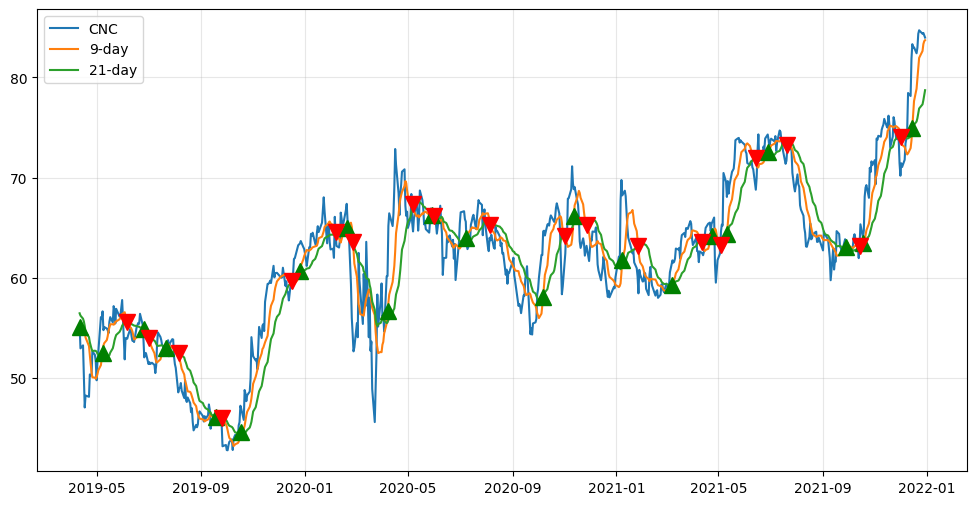

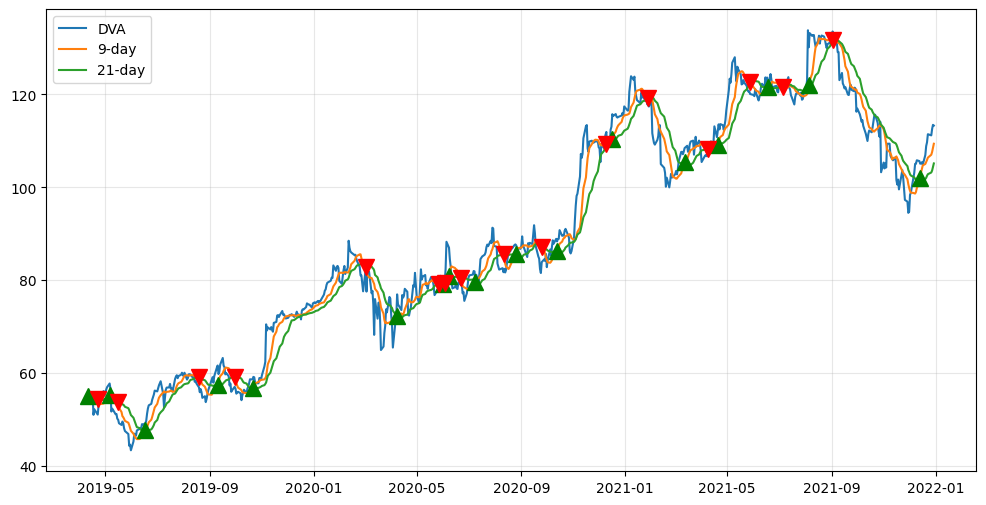

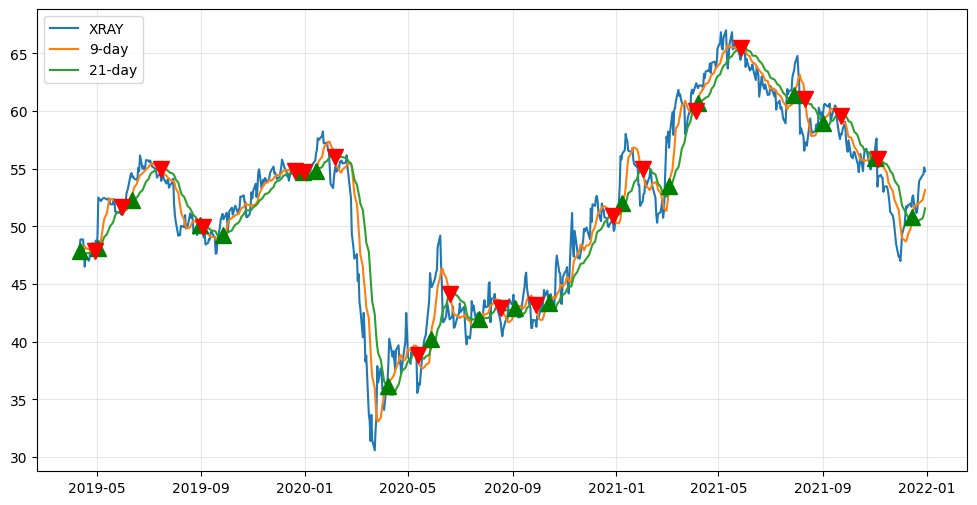

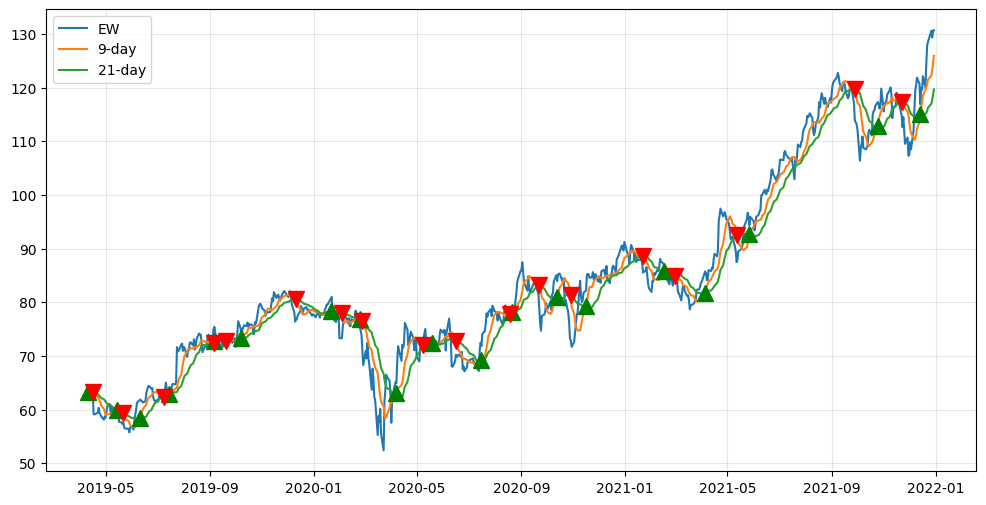

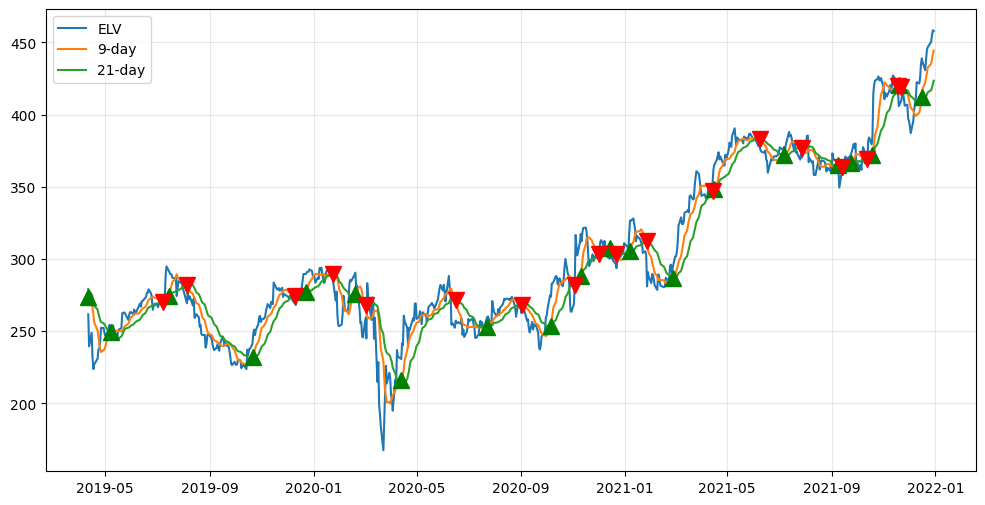

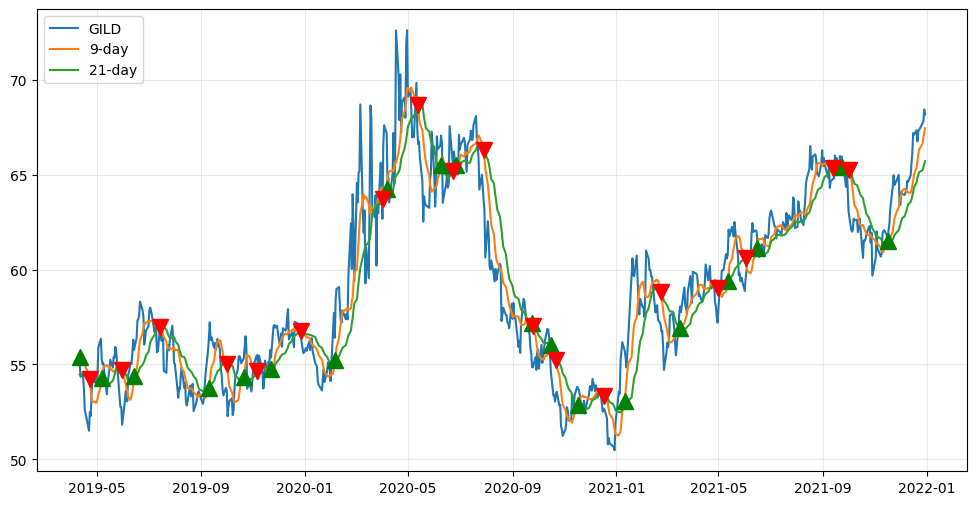

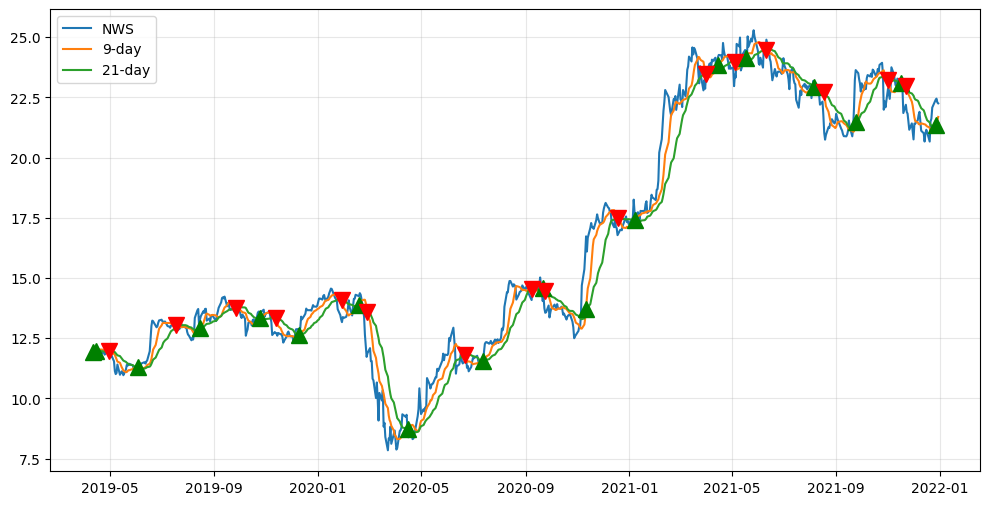

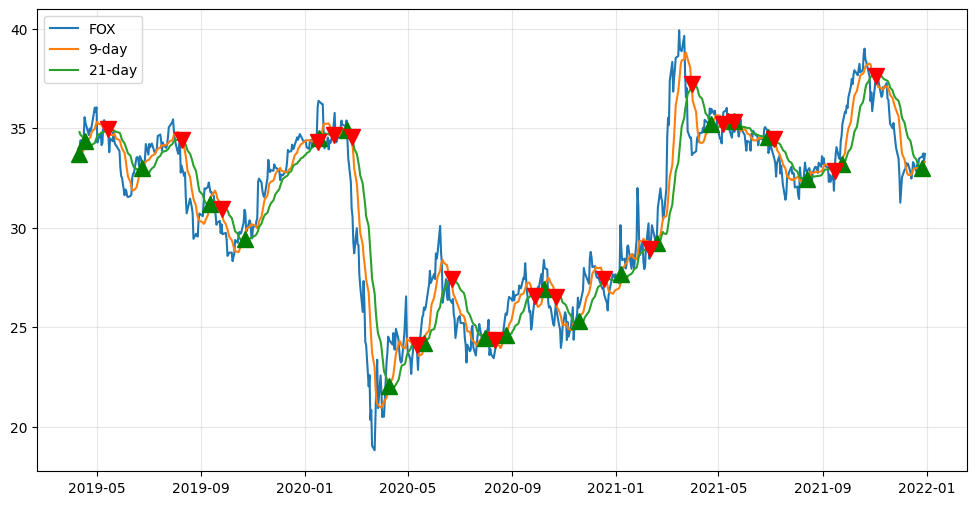

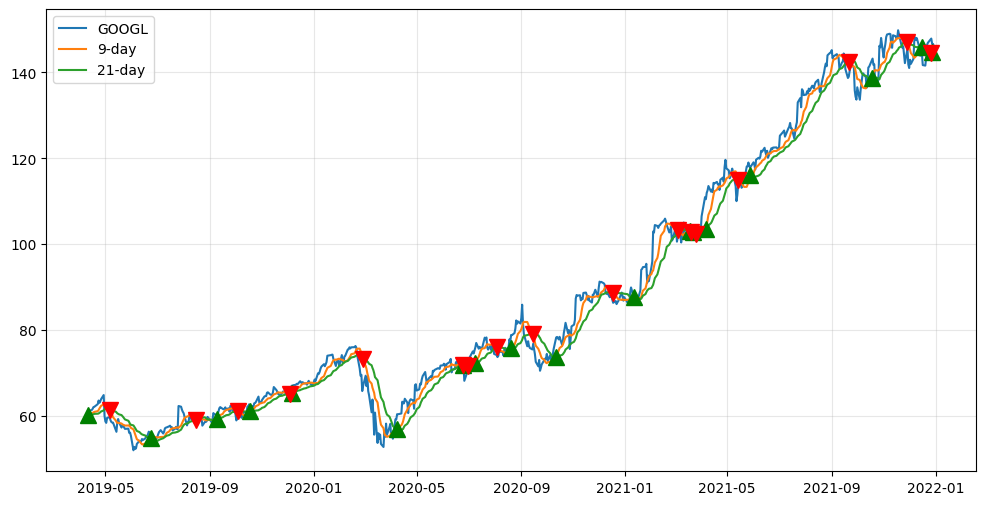

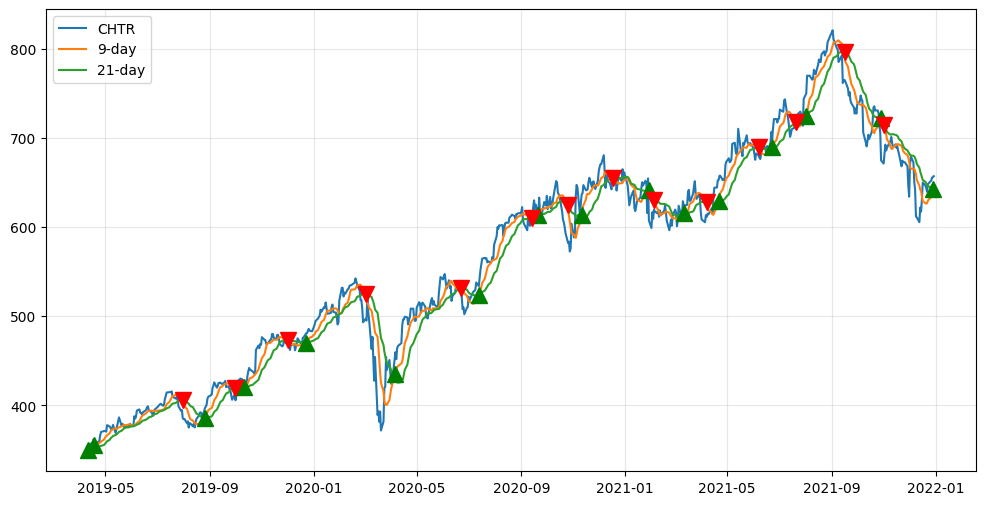

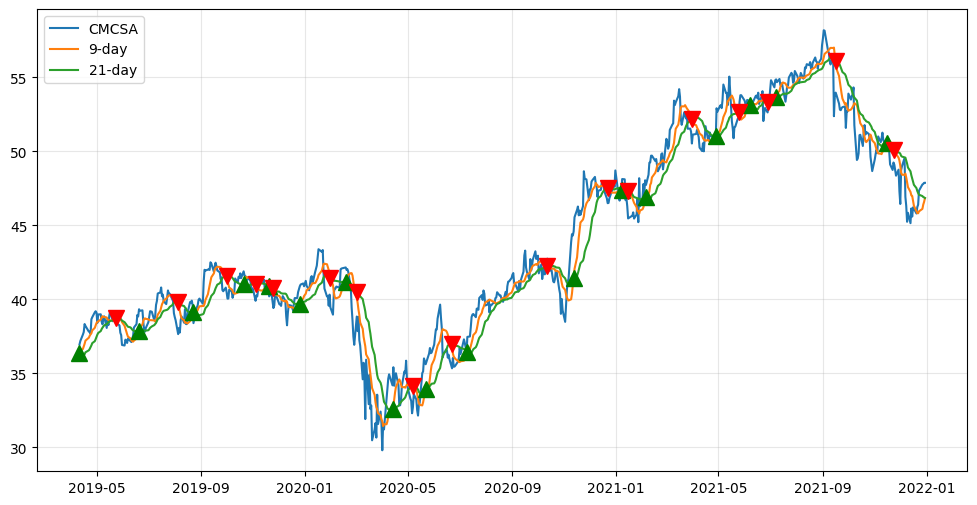

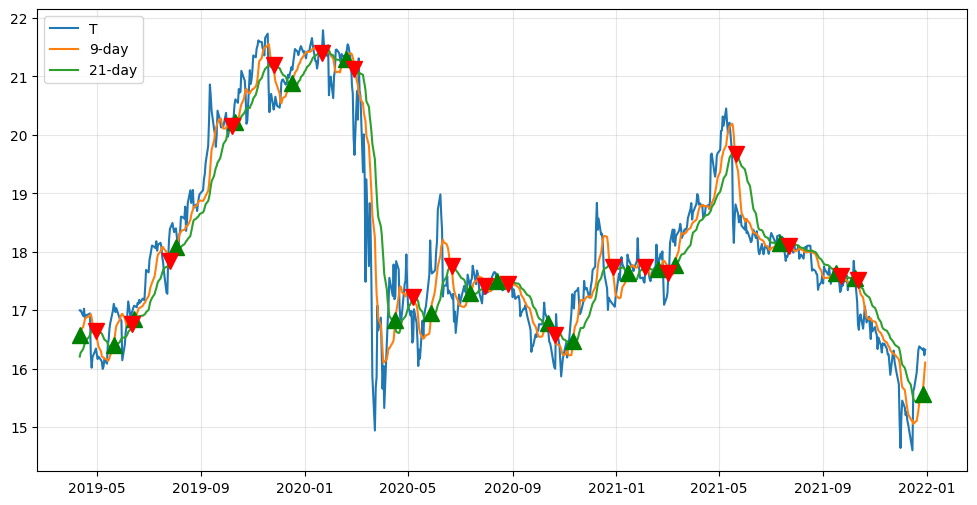

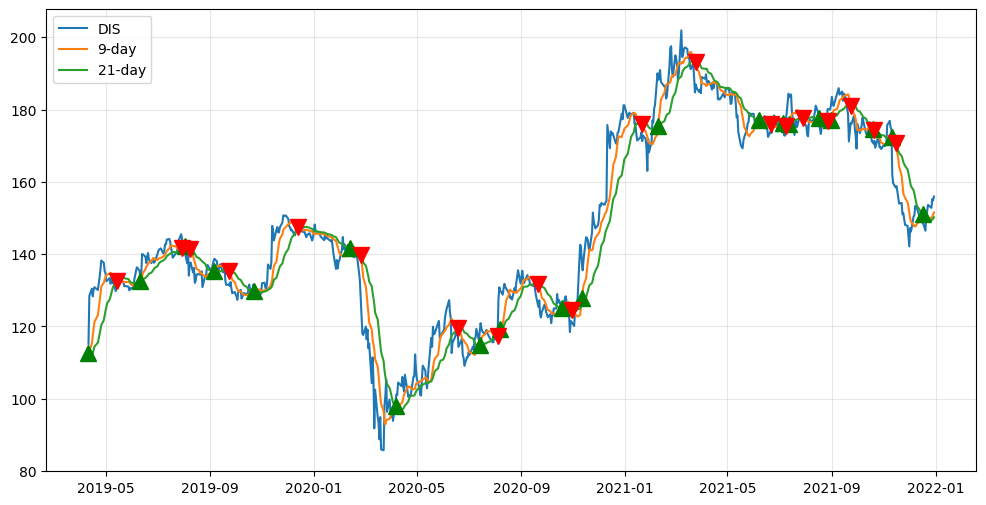

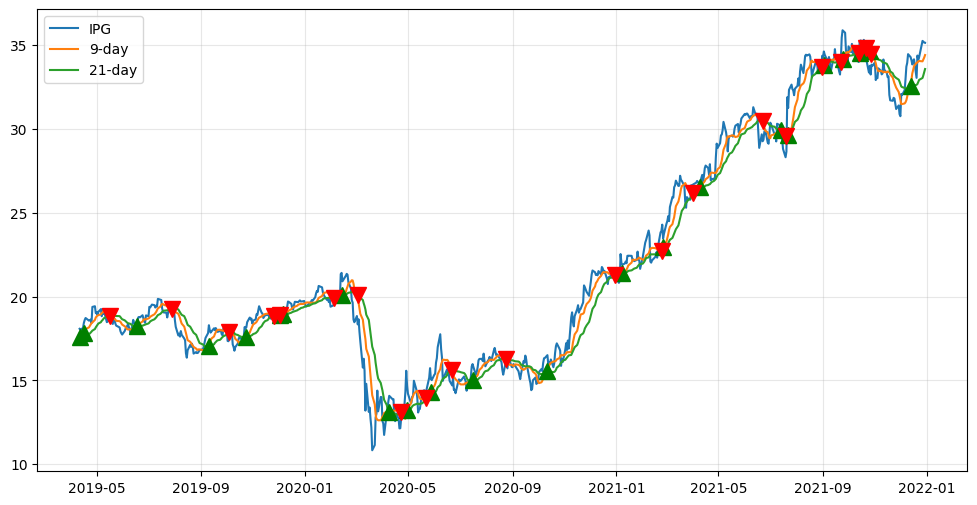

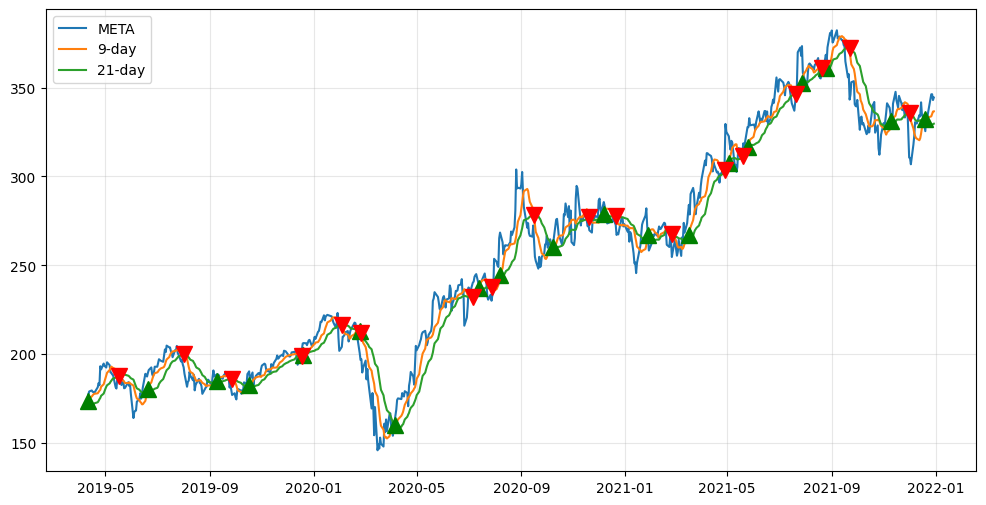

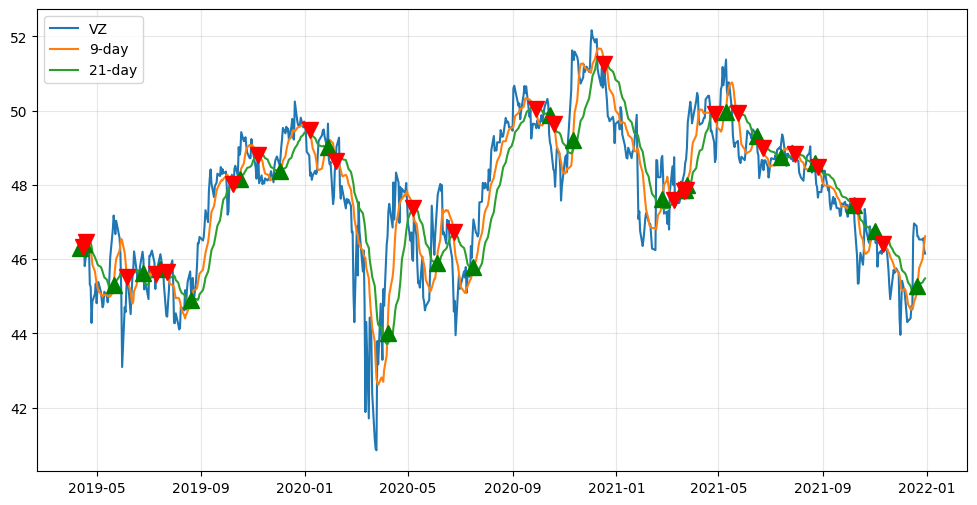

In [ ]:
# show all time
# if you squint closely you should see 34 red triangles
# and 34 green triangles!
c = 0
for ticker in tickers_list:
    plt.figure(c)
    c+=1
    plt.rcParams['figure.figsize'] = 12, 6
    plt.grid(True, alpha=0.3)
    plt.plot(prep_data.iloc[:][ticker], label=ticker)
    plt.plot(prep_data.iloc[:][f'{ticker}_9-day'], label='9-day')
    plt.plot(prep_data.iloc[:][f'{ticker}_21-day'], label='21-day')
    plt.plot(prep_data[:][prep_data[f'{ticker}_signal'] == 1].index, prep_data[:][f'{ticker}_9-day'][prep_data[f'{ticker}_signal'] == 1], '^',
             color='g', markersize=12)
    plt.plot(prep_data[:][prep_data[f'{ticker}_signal'] == -1].index, prep_data[:][f'{ticker}_21-day'][prep_data[f'{ticker}_signal'] == -1], 'v',
             color='r', markersize=12)

    plt.legend(loc=2)


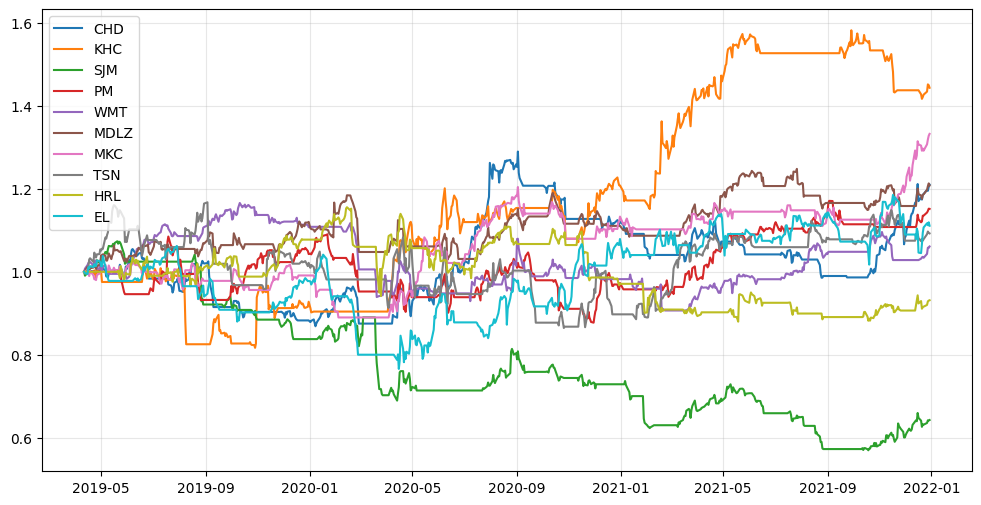

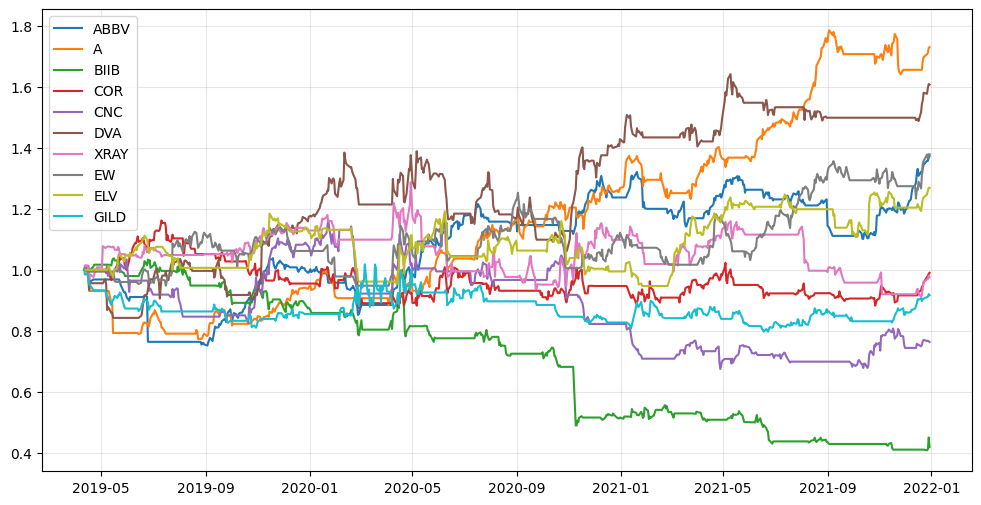

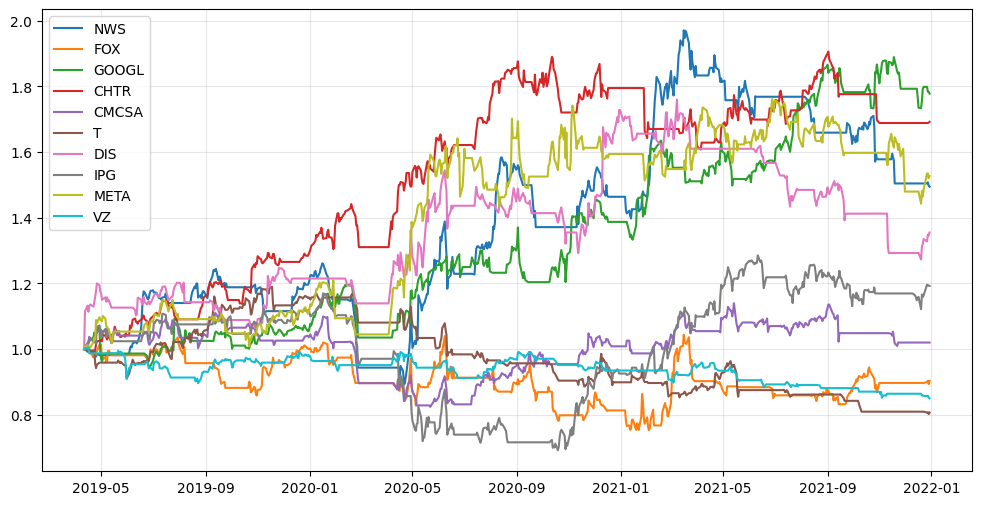

In [ ]:
for i in range(3):
 plt.figure(i)
 plt.rcParams['figure.figsize'] = 12, 6
 for j in range(10):
  plt.plot(np.exp(prep_data[f'{tickers_list[10*i+j]}_system_return']).cumprod(), label=tickers_list[10*i+j])
 plt.legend(loc=2)
 plt.grid(True, alpha=.3)
 plt.show()

In [ ]:
consumerstaples = tickers_list[0:10]
consumerstaple_returns = MT_returns[0:10]
healthcare = tickers_list[10:20]
healthcare_returns = MT_returns[10:20]
communicationservices = tickers_list[20:30]
communicationservices_returns = MT_returns[20:30]

consumerstaple_returns, consumerstaples = zip(*sorted(zip(consumerstaple_returns,
                                                          consumerstaples), reverse = True))

healthcare_returns, healthcare = zip(*sorted(zip(healthcare_returns,
                                                          healthcare), reverse = True))

communicationservices_returns, communicationservices = zip(*sorted(zip(communicationservices_returns,
                                                          communicationservices), reverse = True))


print(consumerstaples)
print(consumerstaple_returns)
print(healthcare)
print(healthcare_returns)
print(communicationservices)
print(communicationservices_returns)

top9_stocks_list = list(consumerstaples[0:3] ) + list(healthcare[0:3]) + list(communicationservices[0:3])

print("Top 9 stocks ", ":" , top9_stocks_list)


('KHC', 'MKC', 'CHD', 'MDLZ', 'PM', 'EL', 'TSN', 'WMT', 'HRL', 'SJM')
(0.44323232774006627, 0.33212852013074046, 0.20989981144154957, 0.20793232289088026, 0.15150864000164477, 0.11090140267758763, 0.09249660683423366, 0.060972125194584725, -0.0686106294351343, -0.35703061256756063)
('A', 'DVA', 'EW', 'ABBV', 'ELV', 'COR', 'XRAY', 'GILD', 'CNC', 'BIIB')
(0.7300675929976188, 0.6069308836195351, 0.37903761806874625, 0.37280706042615863, 0.26794652172245126, -0.009638119091386788, -0.02516200350455433, -0.08322347436800814, -0.23654928393431895, -0.5813375173598108)
('GOOGL', 'CHTR', 'META', 'NWS', 'DIS', 'IPG', 'CMCSA', 'FOX', 'VZ', 'T')
(0.7775671340103094, 0.6919914578905972, 0.5264263130068101, 0.4944396417844965, 0.35496654824886, 0.19255132473495484, 0.02006414400208012, -0.09661249704445496, -0.14941280447380856, -0.19320163890611852)
Top 9 stocks  : ['KHC', 'MKC', 'CHD', 'A', 'DVA', 'EW', 'GOOGL', 'CHTR', 'META']


In [ ]:
#collecting data of top 9 stocks
opt_data = prep_data[top9_stocks_list]
opt_data.head()

KHC        MKC        CHD          A        DVA         EW  \
2019-04-11  26.412189  71.538544  69.634277  78.523430  54.630001  63.453335   
2019-04-12  26.476236  71.454987  69.813797  78.426598  54.540001  63.903332   
2019-04-15  26.532280  71.975098  69.700417  77.864883  55.169998  63.076668   
2019-04-16  26.452215  71.148445  69.511436  75.104767  55.320000  63.463333   
2019-04-17  26.332127  70.804771  69.587044  73.051590  51.049999  59.163334   

                GOOGL        CHTR        META  
2019-04-11  60.479500  355.250000  177.509995  
2019-04-12  61.136501  356.049988  179.100006  
2019-04-15  61.326500  357.339996  179.649994  
2019-04-16  61.595501  358.049988  178.869995  
2019-04-17  62.007000  361.690002  178.779999

In [ ]:
# create return features for each ticker,
# we will just use a pct_change as the return
opt_return_data = pd.DataFrame()
for i in top9_stocks_list:
  opt_return_data[i] = opt_data[i].pct_change()
# drop the na records
opt_return_data.dropna(inplace=True)
opt_return_data

KHC       MKC       CHD         A       DVA        EW  \
2019-04-12  0.002425 -0.001168  0.002578 -0.001233 -0.001647  0.007092   
2019-04-15  0.002117  0.007279 -0.001624 -0.007162  0.011551 -0.012936   
2019-04-16 -0.003018 -0.011485 -0.002711 -0.035448  0.002719  0.006130   
2019-04-17 -0.004540 -0.004830  0.001088 -0.027338 -0.077187 -0.067756   
2019-04-18  0.002128  0.012594  0.002444  0.009810  0.023115 -0.001296   
...              ...       ...       ...       ...       ...       ...   
2021-12-23  0.003987 -0.003855  0.001308  0.006506  0.015864  0.005789   
2021-12-27  0.005107  0.011824  0.008339  0.005957 -0.002244  0.015633   
2021-12-28  0.012136  0.008818 -0.001793  0.002772  0.012503 -0.009419   
2021-12-29 -0.001394  0.006950  0.007986  0.009235  0.007729  0.009973   
2021-12-30 -0.004189  0.003360  0.004357  0.001432 -0.001322  0.000306   

               GOOGL      CHTR      META  
2019-04-12  0.010863  0.002252  0.008957  
2019-04-15  0.003108  0.003623  0.003071  
2019-04-16  0.004386  0.001987 -0.004342  
2019-04-17  0.006681  0.010166 -0.000503  
2019-04-18  0.001072 -0.006414 -0.002797  
...              ...       ...       ...  
2021-12-23  0.003425  0.013301  0.014495  
2021-12-27  0.006738  0.006247  0.032633  
2021-12-28 -0.008245  0.005273  0.000116  
2021-12-29 -0.000218  0.000747 -0.009474  
2021-12-30 -0.003099  0.001447  0.004141  

[686 rows x 9 columns]

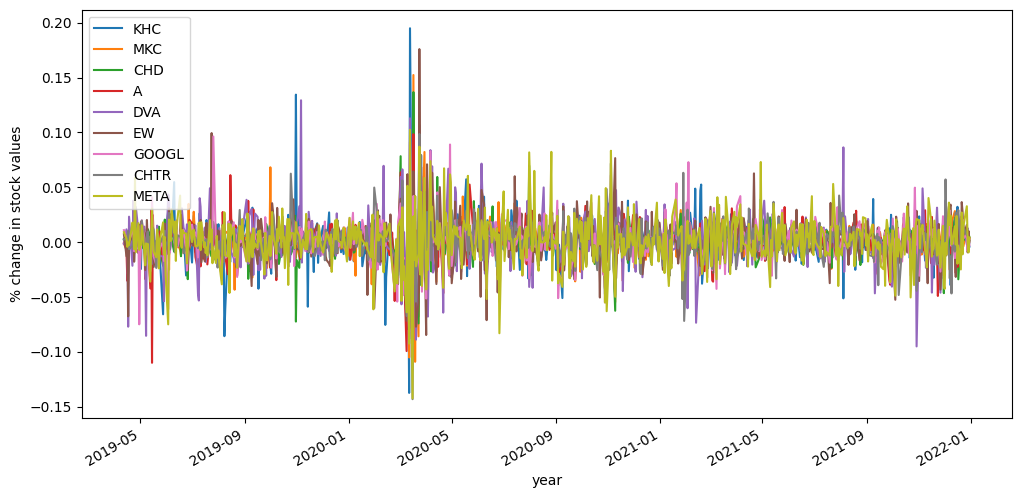

In [ ]:
opt_return_data.plot()
plt.xlabel('year')
plt.ylabel('% change in stock values')
plt.show()

In [ ]:
# creating covariance table on stock return dataframe
opt_return_data_cov = opt_return_data.cov()
print(opt_return_data_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = opt_return_data.mean()
print(df_return)

            KHC       MKC       CHD         A       DVA        EW     GOOGL  \
KHC    0.000440  0.000176  0.000107  0.000172  0.000180  0.000138  0.000156   
MKC    0.000176  0.000288  0.000177  0.000150  0.000116  0.000141  0.000120   
CHD    0.000107  0.000177  0.000238  0.000102  0.000073  0.000099  0.000089   
A      0.000172  0.000150  0.000102  0.000327  0.000171  0.000207  0.000186   
DVA    0.000180  0.000116  0.000073  0.000171  0.000481  0.000165  0.000155   
EW     0.000138  0.000141  0.000099  0.000207  0.000165  0.000440  0.000198   
GOOGL  0.000156  0.000120  0.000089  0.000186  0.000155  0.000198  0.000364   
CHTR   0.000128  0.000109  0.000093  0.000130  0.000114  0.000138  0.000159   
META   0.000166  0.000135  0.000097  0.000193  0.000136  0.000200  0.000302   

           CHTR      META  
KHC    0.000128  0.000166  
MKC    0.000109  0.000135  
CHD    0.000093  0.000097  
A      0.000130  0.000193  
DVA    0.000114  0.000136  
EW     0.000138  0.000200  
GOOGL  0.0001

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables
# each one is a stock (Computer, Chemical, Power, Auto, Electronic)
m.KHC = Var(within=NonNegativeReals, bounds=(0,1))
m.MKC = Var(within=NonNegativeReals, bounds=(0,1))
m.CHD = Var(within=NonNegativeReals, bounds=(0,1))
m.A = Var(within=NonNegativeReals, bounds=(0,1))
m.DVA = Var(within=NonNegativeReals, bounds=(0,1))
m.EW = Var(within=NonNegativeReals, bounds=(0,1))
m.GOOGL = Var(within=NonNegativeReals, bounds=(0,1))
m.CHTR = Var(within=NonNegativeReals, bounds=(0,1))
m.META = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
# declare objective
m.objective = Objective(expr =
                        m.KHC*df_return[0] +
                        m.MKC*df_return[1] +
                        m.CHD*df_return[2] +
                        m.A*df_return[3] +
                        m.DVA*df_return[4]+
                        m.EW*df_return[5]+
                        m.GOOGL*df_return[6]+
                        m.CHTR*df_return[7]+
                        m.META*df_return[8],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.KHC + m.MKC + m.CHD + m.A + m.DVA+ m.EW + m.GOOGL + m.CHTR +m.META == 1)

#Set maximum risk: WE ARE INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS (see below), YOU CAN (and should!) IGNORE IT FOR NOW!
m.total_risk = Constraint(expr = m.KHC + m.MKC + m.CHD + m.A + m.DVA+ m.EW + m.GOOGL + m.CHTR +m.META >= 0.0)

In [ ]:
# creating calculations table for calculate the risk
#  Calculate risk
def calc_risk(m):
  variables = [m.KHC, m.MKC, m.CHD, m.A, m.DVA, m.EW , m.GOOGL , m.CHTR ,m.META]
  tickers = ["KHC","MKC","CHD","A","DVA","EW" ,"GOOGL","CHTR","META"]
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*opt_return_data_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)


max_risk = 0.0004
# Sequence of risk levels
risk_limits = np.arange(0.00001, max_risk, 0.0000005) # take tiny steps
risk_limits
len(risk_limits)

780

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # MAY NOT FILTER ALL INFEASIBLE OUTCOMES IN REAL-WORLD INSTANCES
  # # If solution is not feasible, ignore this run
  # if result.solver.termination_condition == TerminationCondition.infeasible:
  #   continue

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue



  result = result.write()

  # store our allocation proportions
  #param_analysis[r] = [m.KHC(), m.MKC(), m.CHD(), m.A(), m.DVA(), m.EW() , m.GOOGL() , m.CHTR(),m.META()]
  param_analysis[r] = {
    'KHC': m.KHC(),
    'MKC': m.MKC(),
    'CHD': m.CHD(),
    'A': m.A(),
    'DVA': m.DVA(),
    'EW': m.EW(),
    'GOOGL': m.GOOGL(),
    'CHTR': m.CHTR(),
    'META': m.META()
}
  # store our returns
  returns[r] =  m.KHC()*df_return[0] + m.MKC()*df_return[1] + m.CHD()*df_return[2] + m.A()*df_return[3] +m.DVA()*df_return[4]+m.EW()*df_return[5]+m.GOOGL()*df_return[6]+m.CHTR()*df_return[7]+m.META()*df_return[8]


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.015018224716186523
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# -----------------------

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')


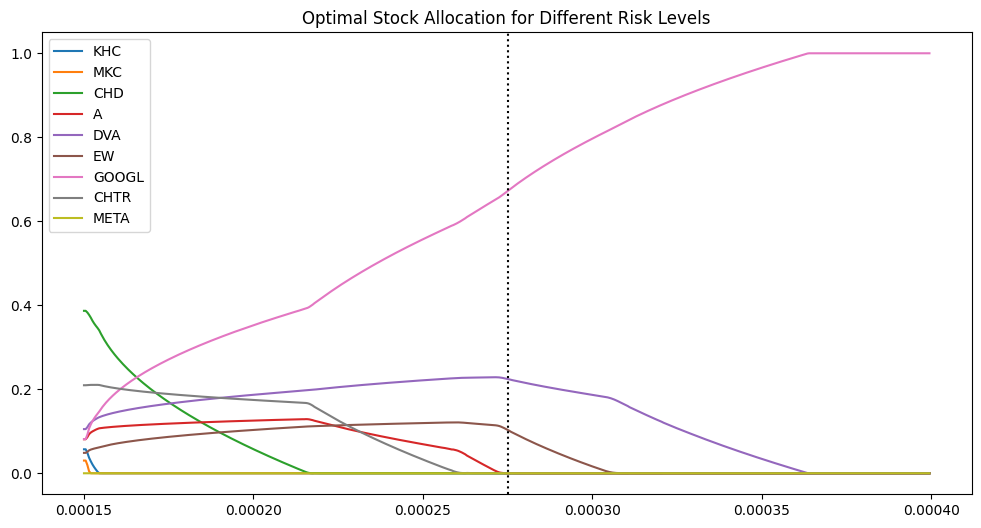

In [ ]:
param_analysis.columns =["KHC","MKC","CHD","A","DVA","EW" ,"GOOGL","CHTR","META"]
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.axvline(x = 0.0002750000000000002, color = 'black', linestyle= 'dotted')
plt.legend()
plt.show()

In [ ]:
portfolio= param_analysis.loc[0.0002750000000000002].round(3)
#param_analysis.loc[0.00030000000000002].round(3)


In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.0001500000000000001, 0.00015050000000000008, 0.0001510000000000001, 0.00015150000000000008, 0.0001520000000000001, 0.00015250000000000007, 0.0001530000000000001, 0.00015350000000000007, 0.00015400000000000008, 0.0001545000000000001, 0.00015500000000000008, 0.0001555000000000001, 0.00015600000000000008, 0.0001565000000000001, 0.00015700000000000008, 0.0001575000000000001, 0.00015800000000000007, 0.00015850000000000009, 0.0001590000000000001, 0.00015950000000000008, 0.0001600000000000001, 0.00016050000000000008, 0.0001610000000000001, 0.00016150000000000008, 0.0001620000000000001, 0.0001625000000000001, 0.00016300000000000009, 0.0001635000000000001, 0.00016400000000000008, 0.0001645000000000001, 0.00016500000000000008, 0.0001655000000000001, 0.0001660000000000001, 0.0001665000000000001, 0.0001670000000000001, 0.0001675000000000001, 0.0001680000000000001, 0.00016850000000000008, 0.0001690000000000001, 0.00016950000000000008, 0.0001700000000000001, 0.0001705000000000001, 0.0001710000000

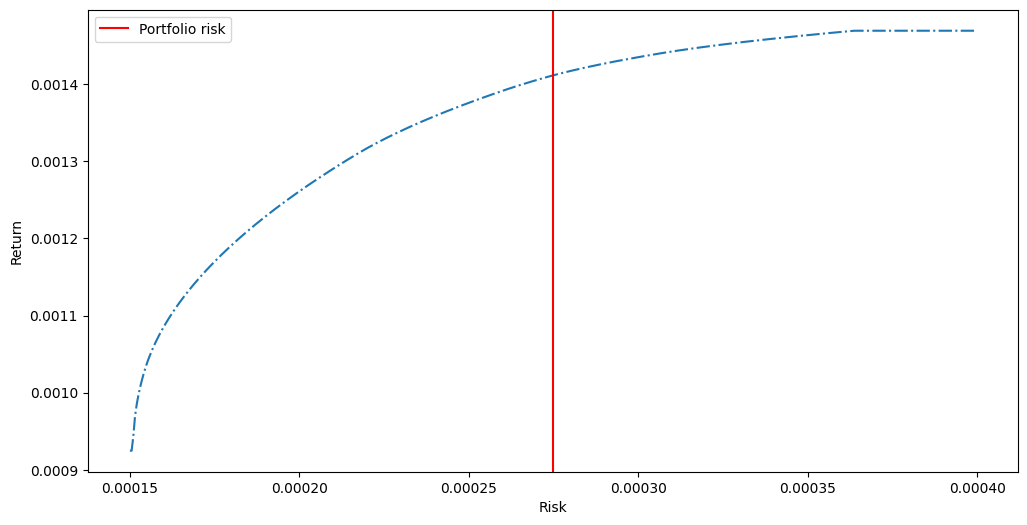

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('')
xlabel('Risk')
ylabel('Return')
plt.axvline(x = 0.0002750000000000002, color = 'red' , label = 'Portfolio risk')
plt.legend()
plt.show()

In [ ]:
portfolio = portfolio.loc[portfolio > 0]
portfolio #Top 3 stocks

DVA      0.225
EW       0.103
GOOGL    0.672
Name: 0.0002750000000000002, dtype: float64

Analysis


In [ ]:
port_stocks = portfolio.index #portfolio stocks

top_stocks = [tickers_list.index(i) for i in port_stocks]


# pull historical price data for each portfolio stock for analysis
port_prep_data = {ticker : si.get_data(ticker,start_date = '01/01/2022',end_date='12/31/2022',interval='1d') for ticker in port_stocks }
port_prep_data


{'DVA':                   open        high         low       close    adjclose  \
 2022-01-03  114.070000  115.589996  113.099998  115.430000  115.430000   
 2022-01-04  115.669998  116.519997  114.980003  115.389999  115.389999   
 2022-01-05  115.750000  117.900002  113.900002  114.000000  114.000000   
 2022-01-06  114.110001  114.209999  111.059998  111.279999  111.279999   
 2022-01-07  110.769997  112.629997  110.410004  111.589996  111.589996   
 ...                ...         ...         ...         ...         ...   
 2022-12-23   73.160004   74.000000   73.160004   73.760002   73.760002   
 2022-12-27   73.750000   74.269997   73.379997   73.900002   73.900002   
 2022-12-28   74.070000   74.610001   72.750000   72.800003   72.800003   
 2022-12-29   73.190002   75.290001   73.190002   75.209999   75.209999   
 2022-12-30   74.690002   75.110001   73.900002   74.669998   74.669998   
 
             volume ticker  
 2022-01-03  630600    DVA  
 2022-01-04  562800    DVA  
 202

In [ ]:
port_data = pd.DataFrame()
for i in port_stocks:
  port_data[i] = pd.DataFrame(port_prep_data[i]['adjclose'])
port_data

DVA          EW       GOOGL
2022-01-03  115.430000  128.339996  144.991501
2022-01-04  115.389999  127.889999  144.399506
2022-01-05  114.000000  123.919998  137.774994
2022-01-06  111.279999  123.230003  137.747498
2022-01-07  111.589996  122.300003  137.016998
...                ...         ...         ...
2022-12-23   73.760002   74.190002   89.230003
2022-12-27   73.900002   73.589996   87.389999
2022-12-28   72.800003   73.110001   86.019997
2022-12-29   75.209999   75.209999   88.449997
2022-12-30   74.669998   74.610001   88.230003

[251 rows x 3 columns]

In [ ]:
invest_amt= list(100000*portfolio)
invest_amt

[22500.0, 10300.0, 67200.0]

In [ ]:
port_data['21-day'] = port_data[port_stocks[0]].rolling(21).mean().shift()
port_data.dropna(inplace=True)
port_data['Total_investment'] = 0
for i in port_stocks:
  port_data[i+'invested_amount'] = np.log(port_data[i]).diff()
  port_data.loc['2022-02-02', i+'invested_amount'] = 0
  port_data[i+'invested_amount'] = np.exp(port_data[i+'invested_amount']).cumprod()
  port_data[i+'invested_amount'] = port_data[i+'invested_amount']*invest_amt[list(port_stocks).index(i)]
  port_data['Total_investment']  +=  port_data[i+'invested_amount']

port_data.head()

DVA          EW       GOOGL      21-day  Total_investment  \
2022-02-02  111.300003  112.839996  148.000000  111.786191     100000.000000   
2022-02-03  109.930000  111.589996  143.089996  111.589524      97379.538592   
2022-02-04  109.339996  112.180000  143.292999  111.329524      97406.295240   
2022-02-07  109.010002  111.129997  139.201004  111.107619      95385.753842   
2022-02-08  111.260002  111.419998  139.399002  110.999524      95956.978591   

            DVAinvested_amount  EWinvested_amount  GOOGLinvested_amount  
2022-02-02        22500.000000       10300.000000          67200.000000  
2022-02-03        22223.045274       10185.900386          64970.592932  
2022-02-04        22103.772239       10239.755766          65062.767235  
2022-02-07        22037.061822       10143.911812          63204.780207  
2022-02-08        22491.913562       10170.383006          63294.682023

In [ ]:
sandp500 = pd.DataFrame(si.get_data('^GSPC',start_date = '01/01/2022',end_date='12/31/2022',interval='1d')['adjclose'])
sandp500.head()

adjclose
2022-01-03  4796.560059
2022-01-04  4793.540039
2022-01-05  4700.580078
2022-01-06  4696.049805
2022-01-07  4677.029785

BUY AND HOLD FOR S and P 500


In [ ]:
i = 'adjclose'
sandp500_bh_returns=[]
sandp500.dropna(inplace=True)
sandp500['logClose'] = np.log(sandp500[i])
sandp500['return'] = sandp500['logClose'].diff()
sandp500.iloc[0,2] = 0.0
sandp500_bh_returns.append(np.exp(np.sum(sandp500['return'])) -1)#Buy and hold strategy returns
#print(sandp500_bh_returns)
sandp500.head()

adjclose  logClose    return
2022-01-03  4796.560059  8.475654  0.000000
2022-01-04  4793.540039  8.475024 -0.000630
2022-01-05  4700.580078  8.455441 -0.019583
2022-01-06  4696.049805  8.454477 -0.000964
2022-01-07  4677.029785  8.450419 -0.004058

Momemtum Trading for S and P 500


In [ ]:
sandp500_mt_returns = []
sandp500['8-day'] = sandp500[i].rolling(8).mean().shift()
sandp500['21-day'] = sandp500[i].rolling(21).mean().shift()
sandp500.dropna(inplace=True)
sandp500['invested'] = np.where(sandp500['8-day'] > sandp500['21-day'], 1, 0)
sandp500['signal'] = sandp500['invested'].diff()
sandp500.iloc[0,6] = 1.0
sandp500['system_return'] = sandp500['invested'] * sandp500['return']
sandp500_mt_returns.append(np.exp(np.sum(sandp500['system_return'])) -1)
print(sandp500_mt_returns)
sandp500.head()

[-0.07531758991244375]


adjclose  logClose    return        8-day       21-day  \
2022-02-02  4589.379883  8.431500  0.009378  4416.862488  4572.516625   
2022-02-03  4477.439941  8.406807 -0.024693  4440.792480  4562.650902   
2022-02-04  4500.529785  8.411950  0.005144  4449.206238  4547.598517   
2022-02-07  4483.870117  8.408242 -0.003709  4467.216187  4538.072312   
2022-02-08  4521.540039  8.416608  0.008366  4483.958679  4527.968517   

            invested  signal  system_return  
2022-02-02         0     1.0            0.0  
2022-02-03         0     0.0           -0.0  
2022-02-04         0     0.0            0.0  
2022-02-07         0     0.0           -0.0  
2022-02-08         0     0.0            0.0

In [ ]:
print(sandp500)

               adjclose  logClose    return        8-day       21-day  \
2022-02-02  4589.379883  8.431500  0.009378  4416.862488  4572.516625   
2022-02-03  4477.439941  8.406807 -0.024693  4440.792480  4562.650902   
2022-02-04  4500.529785  8.411950  0.005144  4449.206238  4547.598517   
2022-02-07  4483.870117  8.408242 -0.003709  4467.216187  4538.072312   
2022-02-08  4521.540039  8.416608  0.008366  4483.958679  4527.968517   
...                 ...       ...       ...          ...          ...   
2022-12-23  3844.820068  8.254482  0.005851  3887.898743  3955.666190   
2022-12-27  3829.250000  8.250424 -0.004058  3866.045013  3946.978574   
2022-12-28  3783.219971  8.238331 -0.012093  3845.286255  3937.603806   
2022-12-29  3849.280029  8.255641  0.017311  3831.220001  3928.998093   
2022-12-30  3839.500000  8.253097 -0.002544  3830.834991  3923.838577   

            invested  signal  system_return  
2022-02-02         0     1.0            0.0  
2022-02-03         0     0.0   

In [ ]:
sp_invst = sandp500.iloc[ :,[2,7]]
sp_invst

return  system_return
2022-02-02  0.009378            0.0
2022-02-03 -0.024693           -0.0
2022-02-04  0.005144            0.0
2022-02-07 -0.003709           -0.0
2022-02-08  0.008366            0.0
...              ...            ...
2022-12-23  0.005851            0.0
2022-12-27 -0.004058           -0.0
2022-12-28 -0.012093           -0.0
2022-12-29  0.017311            0.0
2022-12-30 -0.002544           -0.0

[230 rows x 2 columns]

In [ ]:
sp_invst['return'] = 100000* np.exp(sp_invst['return']).cumprod()
sp_invst['system_return'] = 100000*np.exp(sp_invst['system_return']).cumprod()

sp_invst


return  system_return
2022-02-02  100942.251545  100000.000000
2022-02-03   98480.160802  100000.000000
2022-02-04   98988.016085  100000.000000
2022-02-07   98621.590895  100000.000000
2022-02-08   99450.131313  100000.000000
...                   ...            ...
2022-12-23   84565.846453   92468.241009
2022-12-27   84223.386731   92468.241009
2022-12-28   83210.967861   92468.241009
2022-12-29   84663.942168   92468.241009
2022-12-30   84448.832893   92468.241009

[230 rows x 2 columns]

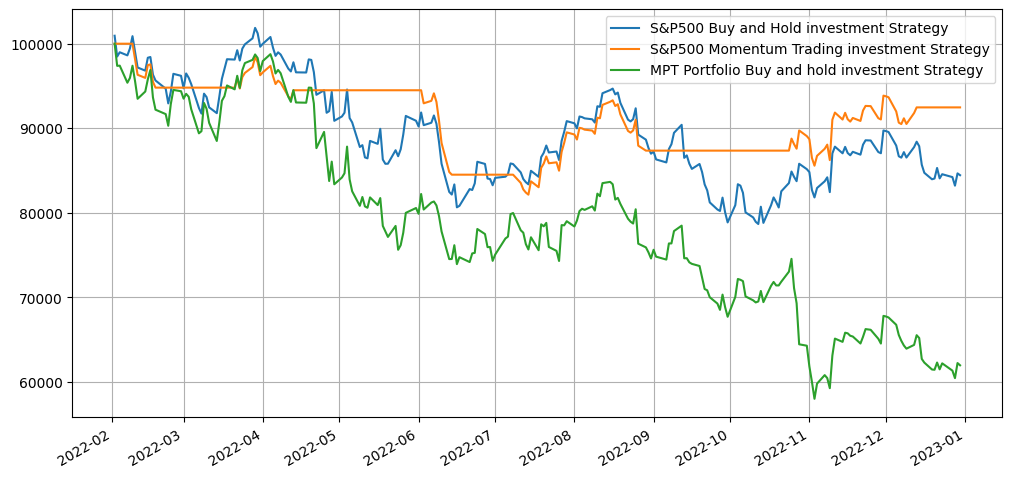

In [ ]:
lines = sp_invst.plot()


port_data['Total_investment'].plot()
plt.legend( ['S&P500 Buy and Hold investment Strategy',
             'S&P500 Momentum Trading investment Strategy',
             'MPT Portfolio Buy and hold investment Strategy'])
plt.grid()
plt.show()